<center><font size="6"><b>Anticipez les besoins en consommation de bâtiments</b></font></center>


### Prédiction des Émissions de CO2 et de la Consommation Totale d'Énergie des Bâtiments Non Résidentiels


<a id='sec:introduction'></a>
## I. Introduction
   

Dans ce deuxième notebook, les données ont été divisées en ensembles d'entraînement et de test. La variable cible a été sélectionnée et sept méthodes d'apprentissage automatique différentes ont été appliquées pour construire les modèles de prédiction. L'évaluation des performances de chaque modèle a été réalisée en utilisant le score R2, et une optimisation des hyperparamètres a été effectuée grâce à la validation croisée afin d'améliorer la précision des prédictions.

Enfin, feature importance dans les modèles a été évaluée en utilisant les modules Lime et Shap. Cette approche a permis d'obtenir une meilleure compréhension des facteurs clés influençant les émissions de CO2 et la consommation d'énergie des bâtiments non résidentiels. Ces analyses ont contribué à approfondir les relations entre les variables et à interpréter plus précisément les résultats obtenus.

### Table des Matières
* [I. Introduction](#sec:introduction)
* [II. Separation des données en ensembles d'entraînement et de test](#sec:selection-variables-pertinentes)
* [III. Modèles de régression](#sec:modeles-regression)
   * [A. Modèle baseline:  Régression linéaire multivariée](#subsec:linear)
   * [B. Modèles linéaires : ElasticNet, Lasso et Ridge](#subsec:elastic)
   * [C. Modèle Support Vector Regression (SVR)](#subsec:SVR)
   * [D. Modèles non-linéaires : XGBoost et RandomForestRegressor](#subsec:Nonlinear)
* [IV. Sélection des meilleurs modèles](#sec:selection-meilleurs-modeles)
   * [A. Emissions de CO2](#subsec:CO2)
   * [B. Consommation d'énergie totale](#subsec:Energy)
* [V. Feature Importance](#sec:feature-importance)
    * [A. Lime](#subsec:Lime)
    * [B. SHAP](#subsec:SHAP)
* [VI. Conclusion](#sec:conc)


In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
import time

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [92]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [93]:
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.8.3
pandas - 2.0.2
numpy - 1.23.5
seaborn - 0.12.1
missingno - 0.4.2
cufflinks - 0.17.3
xgboost - 1.7.5
shap - 0.41.0
matplotlib -  3.6.2


In [94]:
df=pd.read_csv('data_clean.csv')

In [95]:
display(df.columns.to_list())

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal_m2',
 'PropertyGFAParking_m2',
 'PropertyGFABuilding(s)_m2',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA_m2',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA_m2',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA_m2',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge',
 'SiteEnergyUse(kBtu)_total',
 'YearGroup',
 'SteamRatio',
 'ElectricityRatio',
 'NaturalGasRatio',
 'most_steam',
 'most

Dans cette étape préliminaire de l'analyse, j'ai examiné les colonnes du jeu de données pour identifier les variables catégorielles et numériques. J'ai également supprimé la colonne "ENERGYSTARScore" pour pouvoir la réintégrer dans une étape ultérieure. Enfin, j'ai visualisé la présence de données manquantes dans le jeu de données. Ces étapes m'ont permis d'obtenir une vue d'ensemble des caractéristiques du jeu de données et de préparer les étapes suivantes de la modélisation et de la prédiction.

In [96]:
#sauvegarde séparée du energy star score
energy_star_score = df['ENERGYSTARScore']
df.drop('ENERGYSTARScore', axis=1, inplace=True)

<AxesSubplot: >

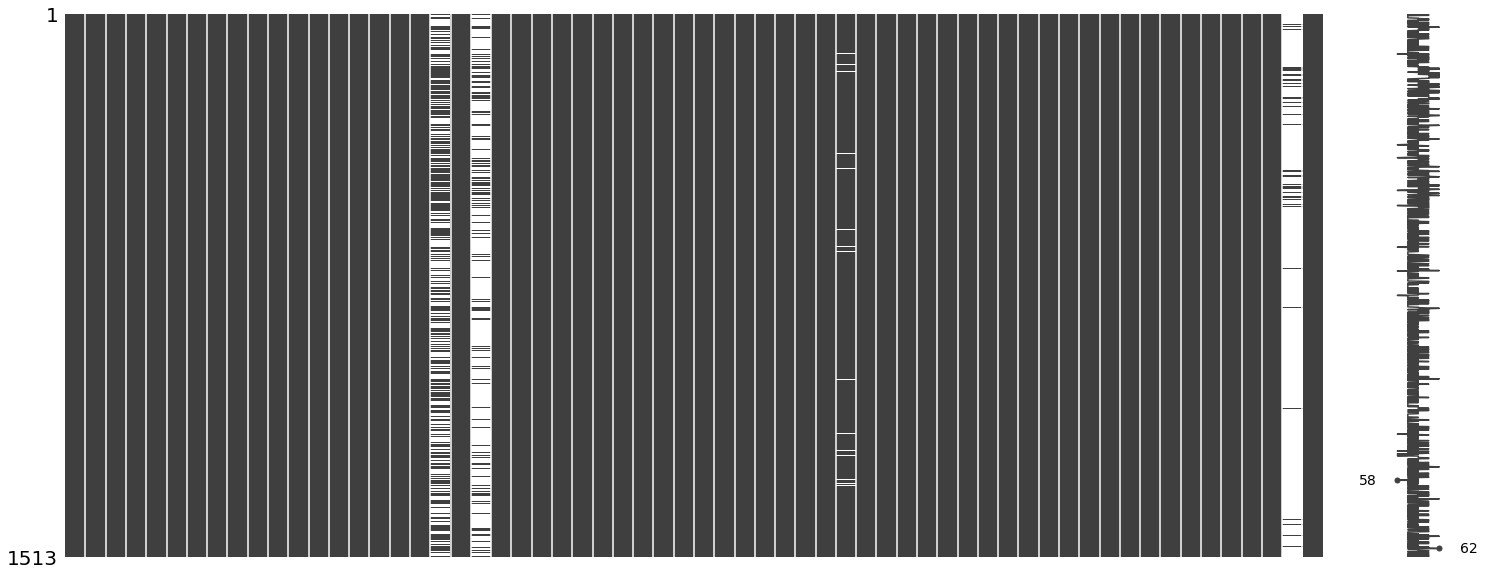

In [97]:
msno.matrix(df)

In [98]:
df.select_dtypes(['int','float']).columns

Index(['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal_m2', 'PropertyGFAParking_m2',
       'PropertyGFABuilding(s)_m2', 'LargestPropertyUseTypeGFA_m2',
       'SecondLargestPropertyUseTypeGFA_m2',
       'ThirdLargestPropertyUseTypeGFA_m2', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'BuildingAge', 'SiteEnergyUse(kBtu)_total', 'YearGroup', 'SteamRatio',
       'ElectricityRatio', 'NaturalGasRatio', 'most_steam', 'most_electricity',
       'most_gas', 'log_energie', 'log_emission', 'MeanGFAperFloor',
       'ParkingGFARatio', 'Miscellaneous Facilities_ratio',
       'Entertainment and Recreation Facilities_

In [99]:
df.select_dtypes('object').columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'YearsENERGYSTARCertified', 'category_building'],
      dtype='object')

<a id='sec:selection-variables-pertinentes'></a>
## II. Separation des données en ensembles d'entraînement et de test


Maintenant, nous allons créer un modèle de référence pour évaluer les performances de nos futurs modèles et vérifier s'ils améliorent les prédictions. Pour ce modèle de référence, nous utiliserons une régression linéaire multivariée.

In [100]:
from sklearn.model_selection import train_test_split
from sklearn import set_config


# Copie des colonnes d'intérêt dans le DataFrame y
y = df.copy()[['log_energie','log_emission','BuildingType', 'category_building', 'BuildingAge']]

# Suppression des colonnes d'intérêt du DataFrame X
X = df.copy()

# Configuration de l'affichage
set_config(display='diagram')

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
X_train.shape

(1210, 62)

In [102]:
X_test.shape

(303, 62)

Nous avons divisé les données en ensembles d'entraînement et de test à l'aide de la fonction train_test_split afin d'évaluer les performances du modèle sur des données non vues.

Nous traiterons les colonnes dans l'ensemble de données X en utilisant un "column transformer".
Pour la division des données y, nous avons utilisé les valeurs logarithmiques des variables cibles.

In [103]:
# Définition des noms des colonnes catégorielles et numériques
cat_cols = ['Neighborhood', 'BuildingType', 'ZipCode']

num_cols = [
    'BuildingAge',
    'MeanGFAperFloor',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal_m2',
    'PropertyGFAParking_m2',
    'PropertyGFABuilding(s)_m2',
    'NumYearsENERGYSTARCertified',
    'YearsSinceCertified'
]

other_col = [
    'most_steam',
    'most_electricity',
    'most_gas',
    'Miscellaneous Facilities_ratio',
    'Entertainment and Recreation Facilities_ratio',
    'Educational Facilities_ratio',
    'Commercial Facilities_ratio',
    'Industrial Facilities_ratio',
    'Healthcare Facilities_ratio',
    'Residential Facilities_ratio',
    'ParkingGFARatio',
    'SLP_Ratio',
    'TLP_Ratio',
    'SteamRatio',
    'ElectricityRatio',
    'NaturalGasRatio'
]

J'ai divisé les colonnes en trois groupes. Le premier groupe contient les colonnes catégorielles, qui doivent être traitées par encodage. Le deuxième groupe contient les colonnes numériques, dont les valeurs ont été placées dans un "standard scaler". Le dernier groupe contient les autres colonnes, pour lesquelles je n'ai appliqué aucune transformation, les acceptant telles quelles.

<a id='sec:modeles-regression'></a>
## III. Modèles de régression

Dans ce projet, nous avons exploré différentes méthodes d'apprentissage automatique pour prédire la consommation d'énergie des bâtiments à Seattle. Nous avons évalué la performance de ces méthodes en utilisant deux métriques : le coefficient de détermination (R2) et l'erreur absolue moyenne négative (MAE).

<a id='subsec:linear'></a>
### A. Modèle baseline:  Régression linéaire multivariée


La régression linéaire est une méthode simple mais puissante pour modéliser les relations linéaires entre les variables. Dans notre projet, nous l'avons utilisée comme méthode de référence pour comparer les performances des autres modèles d'apprentissage automatique.

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder

# Création du transformateur de colonnes avec encodage one-hot
one_hot_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_cols),  # Standardisation des colonnes numériques
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), cat_cols),  # Encodage one-hot des colonnes catégorielles
        ('passthrough', 'passthrough', other_col)  # Passthrough des autres colonnes
    ],
    remainder='drop'
)

# Création du transformateur de colonnes avec encodage target
target_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_cols),  # Standardisation des colonnes numériques
        ('target', TargetEncoder(), cat_cols),  # Encodage target des colonnes catégorielles
        ('passthrough', 'passthrough', other_col)  # Passthrough des autres colonnes
    ],
    remainder='drop'
)


# Objet GridSearchCV pour toutes les techniques d'encodage
grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [-1, None, 1, 2],
        'positive': [True, False]
    },
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2'
)

# Pipelines avec les transformateurs de colonnes et GridSearchCV pour chaque encodage
one_hot_pipeline = Pipeline([
    ('column_transformer', one_hot_transformer),
    ('grid_search', grid_search)
])

target_pipeline = Pipeline([
    ('column_transformer', target_transformer),
    ('grid_search', grid_search)
])



Pour optimiser les paramètres de la régression linéaire, nous avons utilisé l'objet GridSearchCV. Cet objet nous permet d'effectuer une recherche en grille pour trouver les meilleurs paramètres pour notre modèle. Dans notre cas, nous avons spécifié les paramètres suivants : fit_intercept (ajustement de l'ordonnée à l'origine), copy_X (copie des données), n_jobs (nombre de tâches en parallèle) et positive (contrainte des coefficients positifs).

Nous avons utilisé une validation croisée avec 5 plis pour évaluer les performances de chaque combinaison de paramètres. Les métriques utilisées pour évaluer la performance étaient le coefficient de détermination (R2) et l'erreur absolue moyenne négative (MAE). Nous avons choisi le R2 comme métrique principale pour la régression linéaire.

Le StandardScaler est utilisé pour normaliser les valeurs des colonnes numériques, ce qui les mettra à la même échelle et facilitera l'entraînement des modèles.

La conversion des valeurs catégorielles en colonnes indicatrices est une étape importante. Les deux techniques à considérer sont __*Target Encoding*__ et __*OneHot Encoding*__.

__*Target Encoding*__  consiste à remplacer chaque catégorie par une agrégation statistique de la variable cible, telle que la consommation énergétique moyenne pour chaque quartier ou type de bâtiment. Cette technique peut être bénéfique lorsqu'il existe une corrélation entre la variable catégorielle et la variable cible. Cependant, des précautions doivent être prises pour éviter toute fuite de données, telles que l'utilisation de la validation croisée pour calculer les statistiques agrégées.

__*OneHot Encoding*__, quant à lui, crée des colonnes binaires distinctes pour chaque catégorie, indiquant la présence ou l'absence de cette catégorie. Cette technique représente explicitement chaque catégorie sans supposer aucun ordre ou relation entre elles. Par exemple, elle peut créer des colonnes pour chaque quartier ou type de bâtiment, indiquant si un bâtiment donné appartient à cette catégorie ou non.

Étant donné qu'il n'y a pas de relation ordonnée entre les noms de catégories et les valeurs numériques dans l'ensemble de données, __*Label Encoding*__ peut être négligé pour ce projet. Cependant, il peut être intéressant d'expérimenter avec __*Target Encoding*__  pour capturer toute corrélation potentielle entre les variables catégorielles et la consommation énergétique. Cela permettra de comprendre si certains quartiers ou types de bâtiments ont tendance à avoir des schémas de consommation énergétique différents.

In [105]:
def print_encoding_results(pipeline, encoding_name, target):
    start_time = time.time()
    model = pipeline.fit(X_train, target)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = model.named_steps['grid_search'].best_params_
    best_mae_score = np.max(model.named_steps['grid_search'].cv_results_['mean_test_neg_mean_absolute_error'])
    best_r2_score = model.named_steps['grid_search'].best_score_
    
    print("Meilleurs paramètres ({}) :".format(encoding_name), best_params)
    print("Meilleur score MAE ({}) :".format(encoding_name), '{:.3f}'.format(best_mae_score))
    print("Meilleur score R2 ({}) :".format(encoding_name), '{:.3f}'.format(best_r2_score))
    print("Temps d'entraînement ({}) : {:.2f} secondes".format(encoding_name, training_time))

# Liste des encodages et des pipelines correspondants
encodings = [("One-Hot Encoding", one_hot_pipeline),
             ("Target Encoding", target_pipeline)]

# Liste des variables cibles et de leurs noms correspondants
target_variables = [("Log-TotalGHGEmissions", y_train['log_emission']),
                    ("Log-SiteEnergyUse(kBtu)", y_train['log_energie'])]

# Boucle pour parcourir les encodages et les variables cibles
for encoding_name, pipeline in encodings:
    for target_name, target_variable in target_variables:
        print("Encodage :", encoding_name)
        print("Variable cible :", target_name)
        print_encoding_results(pipeline, encoding_name, target_variable)
        print()


Encodage : One-Hot Encoding
Variable cible : Log-TotalGHGEmissions
Meilleurs paramètres (One-Hot Encoding) : {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': True}
Meilleur score MAE (One-Hot Encoding) : -0.735
Meilleur score R2 (One-Hot Encoding) : 0.588
Temps d'entraînement (One-Hot Encoding) : 1.53 secondes

Encodage : One-Hot Encoding
Variable cible : Log-SiteEnergyUse(kBtu)
Meilleurs paramètres (One-Hot Encoding) : {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': True}
Meilleur score MAE (One-Hot Encoding) : -0.755
Meilleur score R2 (One-Hot Encoding) : 0.193
Temps d'entraînement (One-Hot Encoding) : 1.41 secondes

Encodage : Target Encoding
Variable cible : Log-TotalGHGEmissions
Meilleurs paramètres (Target Encoding) : {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
Meilleur score MAE (Target Encoding) : -0.719
Meilleur score R2 (Target Encoding) : 0.605
Temps d'entraînement (Target Encoding) : 0.45 secondes

Encodage 

Nous avons appliqué deux méthodes d'encodage différentes : l'encodage One-Hot et l'encodage cible (Target Encoding). Nous avons évalué chaque méthode d'encodage avec deux variables cibles : les émissions totales de gaz à effet de serre (Log-TotalGHGEmissions) et la consommation d'énergie du site (Log-SiteEnergyUse(kBtu)).

Le meilleur score pour les émissions logarithmiques (log_emission) est obtenu avec l'encodage Target Encoding. Cependant, il est important de noter que ces résultats sont basés sur les données d'entraînement.

Pour évaluer la performance des modèles sur les données de test, nous avons calculé les métriques suivantes : l'erreur absolue moyenne (MAE) et le coefficient de détermination (R²). Pour cela, nous avons utilisé la fonction metrics_model, qui calcule ces métriques à partir des valeurs réelles et prédites. 

In [14]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(np.abs(diff))
    r2 = 1 - (np.sum(diff**2) / np.sum((y_true - np.mean(y_true))**2))
    dict_metrics = {"Métrique": ["MAE", "R²"], "Résultats": [mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    df_metrics['Résultats'] = df_metrics['Résultats'].apply(lambda x: '{:.3f}'.format(x))
    return df_metrics

def calculate_metrics(encoding_pipeline, target_variable):
    model = encoding_pipeline.fit(X_train, y_train[target_variable])
    predictions = model.predict(X_test)
    metrics = metrics_model(y_test[target_variable], predictions)
    metrics['Résultats'] = metrics['Résultats']
    return metrics

encodings = [("One-Hot Encoding", one_hot_pipeline),
             ("Target Encoding", target_pipeline)]

target_variables = ["log_emission", "log_energie"]

#Itération sur les différentes méthodes d'encodage et les variables cibles pour afficher les métriques correspondantes
for encoding_name, encoding_pipeline in encodings:
    print("Encodage :", encoding_name)
    for target_variable in target_variables:
        print("Variable cible :", target_variable)
        metrics = calculate_metrics(encoding_pipeline, target_variable)
        print(metrics)
        print()


Encodage : One-Hot Encoding
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.715
1       R²     0.569

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.922
1       R²    -1.737

Encodage : Target Encoding
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.696
1       R²     0.598

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.672
1       R²     0.488



Nous pouvons observer que l'encodage Target Encoding donne de meilleures performances que l'encodage One-Hot Encoding pour les deux variables cibles. Dans le cas de log_emission, les deux encodages ont des scores de MAE et de R² similaires, mais pour log_energie, l'encodage One-Hot Encoding présente un problème de convergence avec un R² négatif et un MAE élevé.

Ce problème de convergence dans l'encodage One-Hot Encoding pour les valeurs de log_energie est probablement dû au grand nombre de colonnes générées en raison du grand nombre de valeurs catégoriques. Cela peut entraîner une augmentation de la complexité du modèle et une difficulté à ajuster les coefficients de manière précise, ce qui conduit à une mauvaise performance.

Le pipeline qui utilise l'encodage Target Encoding présente la meilleure performance, car il parvient à capturer les informations importantes des variables catégorielles de manière plus efficace. Il réduit la dimensionnalité des données en utilisant une seule variable encodée, ce qui aide le modèle à généraliser et à mieux prédire les valeurs de la variable cible. De plus, le Target Encoding peut mieux gérer les valeurs catégorielles rares ou absentes, ce qui améliore la performance du modèle global.

In [15]:
# Fonction qui crée un graphique de dispersion des valeurs prédites par rapport aux valeurs réelles
def plot_pred_true(y_true, y_pred, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode='markers', marker=dict(color="#9C3E2D", opacity=0.6),\
                             name="Predicted Values"))
    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()], y=[y_true.min(), y_true.max()], mode='lines',\
                             line=dict(color='red'), name="Bisector"))
    fig.update_layout(xaxis_title="True Values", yaxis_title="Predicted Values",\
                      title="Predicted Values vs True Values | Variable {}".format(title), font=dict(size=12))
    return fig

# Création d'une figure avec une rangée et deux colonnes
fig = make_subplots(rows=1, cols=2)

# Tracé des valeurs prédites par rapport aux valeurs réelles pour la variable cible "TotalGHGEmissions"
# en utilisant le modèle d'encodage cible
target_model_GHG = target_pipeline.fit(X_train, y_train['log_emission'])
GHG_pred_target = target_model_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], GHG_pred_target, title="TotalGHGEmissions (Target Encoding)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.10, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions",\
                   showarrow=False, font=dict(size=18))

# Tracé des valeurs prédites par rapport aux valeurs réelles pour la variable cible "SiteEnergyUse(kBtu)" 
# en utilisant le modèle d'encodage cible
target_model_SUE = target_pipeline.fit(X_train, y_train['log_energie'])
SiteEnergy_pred_target = target_model_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], SiteEnergy_pred_target, title="SiteEnergyUse(kBtu) (Target Encoding)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.89, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu)",\
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Predicted Values vs True Values | Target Encoding", height=500, width=1000)
fig.show()


Ce code génère un graphique séparé pour chaque variable cible, montrant visuellement la correspondance entre les valeurs prédites et les valeurs réelles. Cela nous permet d'évaluer visuellement la performance du modèle pour chaque variable cible et de comparer les prédictions avec les valeurs réelles.

<a id='subsec:elastic'></a>
### B. Modèles linéaires : ElasticNet, Lasso et Ridge



Ce pipeline utilise la régression Lasso avec une recherche par grille pour trouver les meilleurs hyperparamètres du modèle.

In [16]:
from sklearn.linear_model import Lasso

param_lasso = {
'alpha': np.logspace(-2, 2, num=5), # Valeurs d'alpha à tester (échelle logarithmique de 10^-2 à 10^2)
'fit_intercept': [True, False], # Spécifie si l'intercept doit être ajusté ou non
'max_iter': [1000000], # Nombre maximum d'itérations
'precompute': [True, False], # Précalcul des matrices nécessaires à la résolution du modèle
'warm_start': [True, False], # Indique si les poids initiaux du modèle précédent doivent être utilisés pour l'ajustement
'tol': [1e-2, 1e-1], # Tolérance pour la convergence du modèle
'positive': [True, False], # Contrainte sur les coefficients pour qu'ils soient tous positifs
'selection': ['cyclic', 'random'] # Stratégie de sélection des caractéristiques lors de la mise à jour des poids
}

# Création d'un objet GridSearchCV pour la régression Lasso
lasso_grid_search = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_lasso,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Création d'un pipeline pour la régression Lasso
lasso_pipeline = Pipeline([
    ('column_transformer', target_transformer),
    ('grid_search', lasso_grid_search)
])



Ce pipeline utilise la régression Ridge avec une recherche par grille pour trouver les meilleurs hyperparamètres du modèle.

In [19]:
from sklearn.linear_model import Ridge

param_ridge = {
    'alpha': np.logspace(-2, 2, num=5),  # Valeurs de pénalité pour régulariser le modèle (petit, grand)
    'max_iter': [10000, 100000],  # Nombre maximum d'itérations pour l'optimisation
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Méthode de résolution du problème
}

ridge_grid_search = GridSearchCV(
    estimator=Ridge(),  # Modèle de régression Ridge
    param_grid=param_ridge,  # Grille de paramètres à rechercher
    cv=5,  # Nombre de folds pour la validation croisée
    scoring=('r2', 'neg_mean_absolute_error'),  # Métriques de performance à évaluer
    refit='r2',  # Métrique à utiliser pour sélectionner le meilleur modèle
    n_jobs=-1  # Nombre de processus à utiliser pour l'ajustement en parallèle
)

ridge_pipeline = Pipeline([
    ('column_transformer', target_transformer),  # Transformation des colonnes cibles
    ('grid_search', ridge_grid_search)  # Recherche de grille avec régression Ridge
])



Ce pipeline utilise ElasticNet, une combinaison de régularisation L1 et L2, avec une recherche par grille pour trouver les meilleurs hyperparamètres du modèle.

In [20]:
from sklearn.linear_model import ElasticNet

param_elasticnet = {
'alpha': np.logspace(-2, 2, num=5), # Valeurs d'alpha à tester (échelle logarithmique de 10^-2 à 10^2)
'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], # Ratio entre la régularisation L1 et L2
'max_iter': [10000], # Nombre maximum d'itérations
'selection': ['cyclic', 'random'] # Stratégie de sélection des caractéristiques lors de la mise à jour des poids
}

elasticnet_grid_search = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_elasticnet,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

elasticnet_pipeline = Pipeline([
    ('column_transformer', target_transformer),
    ('grid_search', elasticnet_grid_search)
])


In [21]:

# Liste des méthodes de régularisation et des pipelines correspondants
regularization_methods = [("Lasso", lasso_pipeline),
                          ("Ridge", ridge_pipeline),
                          ("ElasticNet", elasticnet_pipeline)]

# Liste des variables cibles et de leurs noms correspondants
target_variables = [("TotalGHGEmissions", y_train['log_emission']),
                    ("SiteEnergyUse(kBtu)", y_train['log_energie'])]

# Boucle pour parcourir les méthodes de régularisation et les variables cibles
for method_name, pipeline in regularization_methods:
    for target_name, target_variable in target_variables:
        print("Regularization Method:", method_name)
        print("Target Variable:", target_name)
        print_encoding_results(pipeline, method_name, target_variable)


Regularization Method: Lasso
Target Variable: TotalGHGEmissions
Meilleurs paramètres (Lasso) : {'alpha': 0.01, 'fit_intercept': False, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'selection': 'random', 'tol': 0.01, 'warm_start': False}
Meilleur score MAE (Lasso) : -0.741
Meilleur score R2 (Lasso) : 0.581
Temps d'entraînement (Lasso) : 2.30 secondes
Regularization Method: Lasso
Target Variable: SiteEnergyUse(kBtu)
Meilleurs paramètres (Lasso) : {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'selection': 'random', 'tol': 0.01, 'warm_start': True}
Meilleur score MAE (Lasso) : -0.717
Meilleur score R2 (Lasso) : 0.470
Temps d'entraînement (Lasso) : 0.75 secondes
Regularization Method: Ridge
Target Variable: TotalGHGEmissions
Meilleurs paramètres (Ridge) : {'alpha': 0.01, 'max_iter': 10000, 'solver': 'svd'}
Meilleur score MAE (Ridge) : -0.719
Meilleur score R2 (Ridge) : 0.605
Temps d'entraînement (Ridge) : 6.56 secondes
Re

Voici une boucle qui parcourt les différentes méthodes de régularisation (Lasso, Ridge, ElasticNet) et les variables cibles (TotalGHGEmissions, SiteEnergyUse(kBtu)). Elle affiche les résultats d'encodage correspondants en utilisant les pipelines associés à chaque méthode de régularisation.

In [22]:
target_variables = ["log_emission", "log_energie"]

for method_name, encoding_pipeline in regularization_methods:
    print("Méthode de régularisation :", method_name)
    for target_variable in target_variables:
        print("Variable cible :", target_variable)
        metrics = calculate_metrics(encoding_pipeline, target_variable)
        print(metrics)
        print()

Méthode de régularisation : Lasso
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.705
1       R²     0.603

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.677
1       R²     0.492

Méthode de régularisation : Ridge
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.696
1       R²     0.598

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.672
1       R²     0.490

Méthode de régularisation : ElasticNet
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.694
1       R²     0.611

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.668
1       R²     0.500



Parmi ces méthodes, la méthode ElasticNet donne les meilleurs résultats en termes de MAE et R² pour les deux variables cibles. ElasticNet est une combinaison de la régularisation L1 (Lasso) et L2 (Ridge), ce qui lui permet de bénéficier des avantages des deux méthodes. Cela lui donne une plus grande flexibilité pour sélectionner les variables importantes (L1) tout en conservant les avantages de la régularisation L2 pour gérer les problèmes de multicollinéarité. Par conséquent, ElasticNet peut mieux s'adapter aux données et fournir de meilleures performances prédictives par rapport aux autres méthodes de régularisation.

In [23]:
# Créer un subplot avec 1 ligne et 2 colonnes
fig = make_subplots(rows=1, cols=2)

# Tracer les valeurs prédites par rapport aux vraies valeurs pour la variable cible "TotalGHGEmissions"
# en utilisant la méthode de régularisation ElasticNet
modele_elasticnet_GHG = elasticnet_pipeline.fit(X_train, y_train['log_emission'])
pred_elasticNet_GHG = modele_elasticnet_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], pred_elasticNet_GHG, title="TotalGHGEmissions (ElasticNet)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.05, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions (ElasticNet)",\
                   showarrow=False, font=dict(size=18))

# Tracer les valeurs prédites par rapport aux vraies valeurs pour la variable cible "SiteEnergyUse(kBtu)"
# en utilisant la méthode de régularisation ElasticNet
modele_elasticnet_SUE = elasticnet_pipeline.fit(X_train, y_train['log_energie'])
pred_elasticNet_SUE = modele_elasticnet_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], pred_elasticNet_SUE, title="SiteEnergyUse(kBtu) (ElasticNet)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.98, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu) (ElasticNet)",\
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Valeurs prédites vs Vraies valeurs | Méthodes de régularisation", height=500, width=1000)
fig.show()


<a id='subsec:SVR'></a>
### C. Modèle Support Vector Regression (SVR)

L'analyse en composantes principales (PCA) est utilisée pour réduire la dimensionnalité des données, et le codage one-hot est choisi pour représenter les variables catégorielles. Dans le pipeline, SVR est utilisé pour l'apprentissage automatique avec une recherche de grille pour optimiser les paramètres.

In [24]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR

# Définir les paramètres pour SVR
param_svr = {
    'kernel': ['linear', 'rbf'],  # Type de noyau (linear: linéaire, rbf: base radiale)
    'C': [0.1, 1, 10],  # Paramètre de régularisation (plus grande valeur de C, plus forte régularisation)
    'epsilon': [0.01, 0.1],  # Marge d'erreur acceptable
}

# Créer l'objet de recherche de grille
svr_grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_svr,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Créer le pipeline
svr_pipeline = Pipeline([
    ('column_transformer', one_hot_transformer),  # Étapes de transformation des colonnes
    ('pca', PCA(n_components=10)),  # Réduction de dimension avec l'analyse en composantes principales (PCA)
    ('grid_search', svr_grid_search)  # Recherche de grille avec SVR
])


In [25]:
print("SVR avec one_hot_encoding")
print("Target Variable: TotalGHGEmissions")
print_encoding_results(svr_pipeline, "SVR", y_train['log_emission'])
print("SVR avec one_hot_encoding")
print("Target Variable: SiteEnergyUse(kBtu)")
print_encoding_results(svr_pipeline, "SVR", y_train['log_energie'])

SVR avec one_hot_encoding
Target Variable: TotalGHGEmissions
Meilleurs paramètres (SVR) : {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Meilleur score MAE (SVR) : -0.674
Meilleur score R2 (SVR) : 0.635
Temps d'entraînement (SVR) : 1.40 secondes
SVR avec one_hot_encoding
Target Variable: SiteEnergyUse(kBtu)
Meilleurs paramètres (SVR) : {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Meilleur score MAE (SVR) : -0.574
Meilleur score R2 (SVR) : 0.630
Temps d'entraînement (SVR) : 1.42 secondes


Le SVR (Support Vector Regression) est un modèle d'apprentissage automatique non linéaire capable de capturer des relations complexes entre les variables. En utilisant le noyau "rbf" (base radiale), il peut modéliser des relations non linéaires dans les données. De plus, en combinant l'encodage one-hot et la réduction de dimension avec PCA, le modèle SVR peut mieux capturer les relations entre les variables catégorielles et numériques, ce qui peut conduire à de meilleures performances par rapport aux méthodes de régression linéaire ou ElasticNet.

In [26]:

print("SVR")
print("Target Variable: TotalGHGEmissions")
metrics_svr_1 = calculate_metrics(svr_pipeline, "log_emission")
print(metrics_svr_1)
print()

print("SVR")
print("Target Variable: SiteEnergyUse(kBtu)")
metrics_svr_2 = calculate_metrics(svr_pipeline, "log_energie")
print(metrics_svr_2)
print()

SVR
Target Variable: TotalGHGEmissions
  Métrique Résultats
0      MAE     0.655
1       R²     0.644

SVR
Target Variable: SiteEnergyUse(kBtu)
  Métrique Résultats
0      MAE     0.582
1       R²     0.594



In [27]:
fig = make_subplots(rows=1, cols=2)

# Plotting predicted values versus true values for the target variable "TotalGHGEmissions" using SVR pipeline 
svr_model_GHG = svr_pipeline.fit(X_train, y_train['log_emission'])
GHG_pred_svr = svr_model_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], GHG_pred_svr, title="TotalGHGEmissions (SVR)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.05, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions (SVR)",
                   showarrow=False, font=dict(size=18))

# Plotting predicted values versus true values for the target variable "SiteEnergyUse(kBtu)" using SVR pipeline 
svr_model_SUE = svr_pipeline.fit(X_train, y_train['log_energie'])
SiteEnergy_pred_svr = svr_model_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], SiteEnergy_pred_svr, title="SiteEnergyUse(kBtu) (SVR)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.94, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu) (SVR)",
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Predicted Values vs True Values | SVR Pipelines", height=500, width=1000)
fig.show()


<a id='subsec:Nonlinear'></a>
### D. Modèles non-linéaires : XGBoost et RandomForestRegressor

RandomForestRegressor et XGBoost sont des méthodes d'apprentissage automatique basées sur des arbres de décision qui permettent de modéliser des relations complexes et non linéaires entre les variables. Elles optimisent leurs paramètres via une recherche de grille pour améliorer les performances de prédiction. Ces méthodes se distinguent des méthodes précédentes en exploitant la puissance des ensembles d'arbres et du boosting.

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Définir les paramètres pour RandomForestRegressor
param_rf = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None],  # Profondeur maximale de chaque arbre (None signifie aucune limite de profondeur)
    'min_samples_split': [2, 5],  # minimum d'échantillons requis pour diviser un nœud interne
    'min_samples_leaf': [1, 2]  # minimum d'échantillons requis pour être une feuille (nœud terminal) de l'arbre
}

# Créer l'objet de recherche de grille
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_rf,
    n_iter=4,  # Update n_iter to match the search space size
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Créer le pipeline RandomForestRegressor
rf_pipeline = Pipeline([
    ('column_transformer', target_transformer),  # Étapes de transformation des colonnes
    ('grid_search', rf_random_search)  # Recherche de grille aléatoire avec RandomForestRegressor
])



# Définir les paramètres pour XGBoost
param_xgb = {
     'n_estimators': [100, 300],    # Nombre d'estimateurs dans l'ensemble (plus d'estimateurs peuvent améliorer
    # les performances mais augmentent le temps d'entraînement)
     'learning_rate': [0.1, 0.01],
    # Taux d'apprentissage (contrôle l'ampleur des mises à jour de modèle à chaque étape d'apprentissage)
     'max_depth': [3, 5],  # Profondeur maximale de chaque arbre dans l'ensemble
     'subsample': [0.8],  # Sous-échantillonnage des échantillons d'entraînement pour chaque arbre
     'colsample_bytree': [0.8],  # Sous-échantillonnage des colonnes (variables) pour chaque arbre
     'gamma': [0.1],  # Seuil pour effectuer une division d'un nœud de l'arbre
     'reg_alpha': [0],  # Terme de régularisation L1 (Lasso) pour les poids des feuilles de l'arbre
     'reg_lambda': [0.2]  # Terme de régularisation L2 (Ridge) pour les poids des feuilles de l'arbre
}


# Créer l'objet de recherche de grille
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_xgb,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)


# Créer le pipeline XGBoost
xgb_pipeline = Pipeline([
    ('column_transformer', target_transformer),  # Étapes de transformation des colonnes
    ('grid_search', xgb_grid_search)  # Recherche de grille avec XGBoost
])



In [107]:
encodings = [("RandomForestRegressor", rf_pipeline),
             ("XGBoost", xgb_pipeline)]


target_variables = [("Log-TotalGHGEmissions", y_train['log_emission']),
                    ("Log-SiteEnergyUse(kBtu)", y_train['log_energie'])]



for encoding_name, pipeline in encodings:
    for target_name, target_variable in target_variables:
        print("Encoding:", encoding_name)
        print("Target Variable:", target_name)
        print_encoding_results(pipeline, encoding_name, target_variable)
        print()

Encoding: RandomForestRegressor
Target Variable: Log-TotalGHGEmissions
Meilleurs paramètres (RandomForestRegressor) : {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Meilleur score MAE (RandomForestRegressor) : -0.542
Meilleur score R2 (RandomForestRegressor) : 0.760
Temps d'entraînement (RandomForestRegressor) : 13.60 secondes

Encoding: RandomForestRegressor
Target Variable: Log-SiteEnergyUse(kBtu)
Meilleurs paramètres (RandomForestRegressor) : {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Meilleur score MAE (RandomForestRegressor) : -0.521
Meilleur score R2 (RandomForestRegressor) : 0.696
Temps d'entraînement (RandomForestRegressor) : 9.24 secondes

Encoding: XGBoost
Target Variable: Log-TotalGHGEmissions
Meilleurs paramètres (XGBoost) : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.2, 'subsample': 0.8}
Meilleur score


Le modèle XGBoost donne les meilleures performances sur les données d'entraînement pour les deux variables cibles. Il obtient des scores MAE et R2 plus élevés par rapport au modèle RandomForestRegressor. Cela peut être dû à la capacité de XGBoost à capturer des relations complexes entre les variables grâce à son approche de boosting basée sur les arbres de décision. De plus, XGBoost s'entraîne plus rapidement que RandomForestRegressor, ce qui est un avantage supplémentaire.

In [108]:
target_variables = ["log_emission", "log_energie"]

for encoding_name, encoding_pipeline in encodings:
    print("Encodage :", encoding_name)
    for target_variable in target_variables:
        print("Variable cible :", target_variable)
        metrics = calculate_metrics(encoding_pipeline, target_variable)
        print(metrics)
        print()


Encodage : RandomForestRegressor
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.546
1       R²     0.728

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.556
1       R²     0.621

Encodage : XGBoost
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.513
1       R²     0.762

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.534
1       R²     0.643



XGBoost donne de bons résultats en raison de sa capacité à capturer des relations complexes entre les variables et à modéliser des interactions non linéaires. Il utilise une approche de boosting qui combine plusieurs arbres de décision pour améliorer progressivement les prédictions. 

In [109]:
# Créer une figure avec 1 ligne et 2 colonnes
fig = make_subplots(rows=1, cols=2)

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "TotalGHGEmissions" 
# en utilisant XGBoost
xgb_model_GHG = xgb_pipeline.fit(X_train, y_train['log_emission'])
GHG_pred_xgb = xgb_model_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], GHG_pred_xgb, title="TotalGHGEmissions (XGBoost)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.05, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions (XGBoost)",\
                   showarrow=False, font=dict(size=18))

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "SiteEnergyUse(kBtu)" 
# en utilisant RandomForestRegressor
xgb_model_SUE = xgb_pipeline.fit(X_train, y_train['log_energie'])
SiteEnergy_pred_xgb = xgb_model_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], SiteEnergy_pred_xgb, title="SiteEnergyUse(kBtu) (XGBoost)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.99, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu) (XGBoost)",\
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Valeurs prédites vs Valeurs réelles | Pipelines d'apprentissage automatique",\
                  height=500, width=1000)
fig.show()


In [116]:
grouped_data = pd.DataFrame({'log_emission': y_test['log_emission'], 'GHG_pred_xgb': GHG_pred_xgb, 'Building_type': y_test['BuildingType']})
grouped_data = grouped_data.groupby('Building_type').mean()


fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['log_emission'],
    name='Mean Log Emission'
))

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['GHG_pred_xgb'],
    name='GHG Prediction'
))

fig.update_layout(
    title='Mean Log Emission and GHG Prediction by Building Type',
    xaxis_title='Building Type',
    yaxis_title='Mean Value'
)

fig.show()



In [118]:
grouped_data = pd.DataFrame({'log_emission': y_test['log_emission'], 'GHG_pred_xgb': GHG_pred_xgb, 'Category_building': y_test['category_building']})
grouped_data = grouped_data.groupby('Category_building').mean()


fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['log_emission'],
    name='Mean Log Emission'
))

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['GHG_pred_xgb'],
    name='GHG Prediction'
))

fig.update_layout(
    title='Mean Log Emission and GHG Prediction by Building Type',
    xaxis_title='Category Building',
    yaxis_title='Mean Value'
)

fig.show()



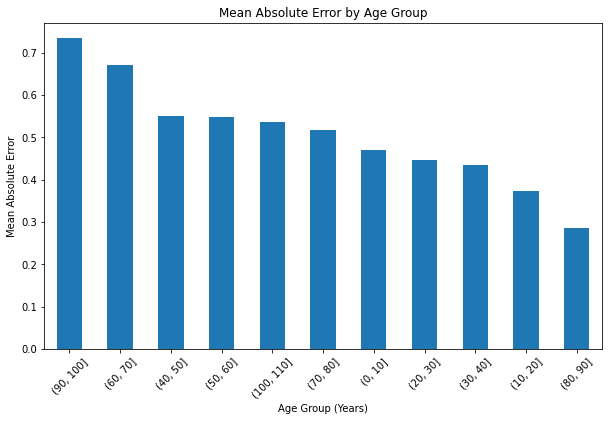

In [130]:
from sklearn.metrics import mean_absolute_error

# Calculate the absolute errors
errors = abs(y_test['log_energie'] - SiteEnergy_pred_xgb)

# Create a DataFrame with errors and BuildingAge
error_data = pd.DataFrame({'Error': errors, 'BuildingAge': y_test['BuildingAge']})

# Group the errors by 10-year intervals
error_data['AgeGroup'] = pd.cut(error_data['BuildingAge'], bins=range(0, 120, 10))

# Calculate the mean absolute error for each group
mean_absolute_errors = error_data.groupby('AgeGroup')['Error'].mean()

# Sort the data by mean absolute error in descending order
mean_absolute_errors_sorted = mean_absolute_errors.sort_values(ascending=False)

# Plot the mean absolute errors by age group
plt.figure(figsize=(10, 6))
mean_absolute_errors_sorted.plot(kind='bar')
plt.xlabel('Age Group (Years)')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Age Group')
plt.xticks(rotation=45)
plt.show()


In [117]:

grouped_data_energy = pd.DataFrame({'log_energie': y_test['log_energie'], 'SiteEnergy_pred_xgb': SiteEnergy_pred_xgb, 'Building_type': y_test['BuildingType']})
grouped_data_energy = grouped_data_energy.groupby('Building_type').mean()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data_energy.index,
    y=grouped_data_energy['log_energie'],
    name='Mean Log Energy'
))

fig.add_trace(go.Bar(
    x=grouped_data_energy.index,
    y=grouped_data_energy['SiteEnergy_pred_xgb'],
    name='Energy Prediction'
))

fig.update_layout(
    title='Mean Log Energy and Energy Prediction by Building Type',
    xaxis_title='Building Type',
    yaxis_title='Mean Value'
)

fig.show()


In [128]:

grouped_data = pd.DataFrame({'log_energie': y_test['log_energie'], 'SiteEnergy_pred_xgb': SiteEnergy_pred_xgb, 'Category_building': y_test['category_building']})
grouped_data = grouped_data.groupby('Category_building').mean()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['log_energie'],
    name='Mean Log Energie'
))

fig.add_trace(go.Bar(
    x=grouped_data.index,
    y=grouped_data['SiteEnergy_pred_xgb'],
    name='Energie Prediction'
))

fig.update_layout(
    title='Mean Log Energie and Energie Prediction by Category Building',
    xaxis_title='Category Building',
    yaxis_title='Mean Value'
)

fig.show()


<a id='sec:selection-meilleurs-modeles'></a>
## IV. Sélection des meilleurs modèles

<a id='subsec:CO2'></a>
### A. Emissions de CO2



In [58]:
models = {
    'GHG_rf_model': rf_pipeline,
    'GHG_xgb_model': xgb_pipeline,
    'GHG_svr_model': svr_pipeline,
    'GHG_ridge_model': ridge_pipeline,
    'GHG_lasso_model': lasso_pipeline,
    'GHG_eNet_model': elasticnet_pipeline,
    'GHG_mlr_model': target_pipeline
}

target_col = 'log_emission'

metrics = ['mean_fit_time', 'mean_score_time', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']

for model_name, model in models.items():
    print(f"Modèle : {model_name}")
    
    # Prétraiter les données avant d'ajuster le modèle
    fitted_model = model.fit(X_train, y_train[target_col])
    
    for metric in metrics:
        if metric in fitted_model.named_steps['grid_search'].cv_results_:
            metric_value = fitted_model.named_steps['grid_search'].cv_results_[metric].mean()
            metric_value_formatted = "{:.3f}".format(metric_value)
            print(f"{metric} : {metric_value_formatted}")
        else:
            print(f"{metric} : N/A")
    
    print()  # Ajouter une ligne vide pour séparer les résultats de chaque modèle


Modèle : GHG_rf_model
mean_fit_time : 4.960
mean_score_time : 0.087
mean_test_neg_mean_absolute_error : -0.544
mean_test_r2 : 0.759

Modèle : GHG_xgb_model
mean_fit_time : 0.552
mean_score_time : 0.004
mean_test_neg_mean_absolute_error : -0.745
mean_test_r2 : 0.532

Modèle : GHG_svr_model
mean_fit_time : 0.190
mean_score_time : 0.033
mean_test_neg_mean_absolute_error : -0.812
mean_test_r2 : 0.447

Modèle : GHG_ridge_model
mean_fit_time : 0.461
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -0.749
mean_test_r2 : 0.567

Modèle : GHG_lasso_model
mean_fit_time : 0.003
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -1.024
mean_test_r2 : 0.183

Modèle : GHG_eNet_model
mean_fit_time : 0.004
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -0.999
mean_test_r2 : 0.220

Modèle : GHG_mlr_model
mean_fit_time : 0.004
mean_score_time : 0.001
mean_test_neg_mean_absolute_error : -0.724
mean_test_r2 : 0.599



XGBoost (GHG_xgb_model) peut avoir de mauvaises performances pour mean_test_r2 en raison de la sensibilité aux paramètres, du surajustement et de la sensibilité aux données. Pour améliorer cela, la solution est d'utiliser la validation croisée imbriquée pour ajuster les paramètres et évaluer les performances de manière plus fiable.

<a id='subsec:Energy'></a>
### B. Consommation d'énergie totale

In [59]:
models = {
    'SUE_rf_model': rf_pipeline,
    'SUE_xgb_model': xgb_pipeline,
    'SUE_svr_model': svr_pipeline,
    'SUE_ridge_model': ridge_pipeline,
    'SUE_lasso_model': lasso_pipeline,
    'SUE_eNet_model': elasticnet_pipeline,
    'SUE_mlr_model': target_pipeline
}

target_col = 'log_energie'

metrics = ['mean_fit_time', 'mean_score_time', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']

for model_name, model in models.items():
    print(f"Modèle : {model_name}")
    
    # Prétraiter les données avant d'ajuster le modèle
    fitted_model = model.fit(X_train, y_train[target_col])
    
    for metric in metrics:
        if metric in fitted_model.named_steps['grid_search'].cv_results_:
            metric_value = fitted_model.named_steps['grid_search'].cv_results_[metric].mean()
            metric_value_formatted = "{:.3f}".format(metric_value)
            print(f"{metric} : {metric_value_formatted}")
        else:
            print(f"{metric} : N/A")
    
    print()  # Ajouter une ligne vide pour séparer les résultats de chaque modèle


Modèle : SUE_rf_model
mean_fit_time : 13.500
mean_score_time : 0.211
mean_test_neg_mean_absolute_error : -0.522
mean_test_r2 : 0.694

Modèle : SUE_xgb_model
mean_fit_time : 1.013
mean_score_time : 0.007
mean_test_neg_mean_absolute_error : -1.784
mean_test_r2 : -3.825

Modèle : SUE_svr_model
mean_fit_time : 0.375
mean_score_time : 0.058
mean_test_neg_mean_absolute_error : -0.671
mean_test_r2 : 0.477

Modèle : SUE_ridge_model
mean_fit_time : 0.770
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -0.707
mean_test_r2 : 0.487

Modèle : SUE_lasso_model
mean_fit_time : 0.004
mean_score_time : 0.003
mean_test_neg_mean_absolute_error : -0.929
mean_test_r2 : 0.116

Modèle : SUE_eNet_model
mean_fit_time : 0.005
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -0.885
mean_test_r2 : 0.213

Modèle : SUE_mlr_model
mean_fit_time : 0.005
mean_score_time : 0.002
mean_test_neg_mean_absolute_error : -0.704
mean_test_r2 : 0.494



Les modèles ElasticNet et Lasso donnent de mauvais scores de mean_test_r2 en raison de leur régularisation, de leur linéarité et de leur sensibilité aux caractéristiques spécifiques des données. Cependant, leur performance peut varier selon d'autres métriques d'évaluation.

Pour obtenir le meilleur score pour les deux variables cibles, j'ai effectué une recherche de grille imbriquée avec XGBoost. Cela signifie que j'ai utilisé une boucle de validation croisée externe pour évaluer les performances globales du modèle et une boucle de validation croisée interne pour ajuster les hyperparamètres du modèle. En utilisant cette approche, j'ai identifié les hyperparamètres optimaux qui ont conduit au meilleur score pour les variables cibles.

Pour simplifier les analyses suivantes, je continuerai à utiliser le pipeline XGBoost avec le meilleur estimateur identifié lors de la recherche de grille.

Je vais donc utiliser le pipeline xgb_pipeline avec le meilleur estimateur pour les analyses SHAP et Lime à venir.

In [60]:
from sklearn.model_selection import cross_val_score, KFold

# Define the parameter grid for XGBoost
param_xgb = {
     'n_estimators': [100, 300],    # Nombre d'estimateurs dans l'ensemble (plus d'estimateurs peuvent améliorer
    # les performances mais augmentent le temps d'entraînement)
     'learning_rate': [0.1, 0.01],
    # Taux d'apprentissage (contrôle l'ampleur des mises à jour de modèle à chaque étape d'apprentissage)
     'max_depth': [3, 5],  # Profondeur maximale de chaque arbre dans l'ensemble
     'subsample': [0.8],  # Sous-échantillonnage des échantillons d'entraînement pour chaque arbre
     'colsample_bytree': [0.8],  # Sous-échantillonnage des colonnes (variables) pour chaque arbre
     'gamma': [0.1],  # Seuil pour effectuer une division d'un nœud de l'arbre
     'reg_alpha': [0],  # Terme de régularisation L1 (Lasso) pour les poids des feuilles de l'arbre
     'reg_lambda': [0.2]  # Terme de régularisation L2 (Ridge) pour les poids des feuilles de l'arbre
}

# Create the GridSearchCV object with nested cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Inner cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Outer cross-validation

xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_xgb,
    cv=inner_cv,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('column_transformer', target_transformer),  # Column transformation steps
    ('grid_search', xgb_grid_search)  # Grid search with XGBoost
])

# Perform nested cross-validation
nested_scores_emi = cross_val_score(xgb_pipeline, X_train, y_train['log_emission'], cv=outer_cv, scoring='r2')

# Print the mean R-squared score across the outer cross-validation folds
print("Mean R² score: {:.3f}".format(nested_scores_emi.mean()))

# Perform nested cross-validation
nested_scores_ene = cross_val_score(xgb_pipeline, X_train, y_train['log_energie'], cv=outer_cv, scoring='r2')

# Print the mean R-squared score across the outer cross-validation folds
print("Mean R² score: {:.3f}".format(nested_scores_ene.mean()))



Mean R² score: 0.772
Mean R² score: 0.707


<a id='sec:feature-importance)'></a>
## V. Feature Importance

In [61]:
# Ajuster le column transformer sur les données d'entraînement
target_transformer.fit_transform(X_train, y_train['log_emission'])

# Obtenir les noms des colonnes transformées
transformed_col_names = num_cols + list(target_transformer.named_transformers_['target'].\
                                        get_feature_names_out(cat_cols)) + other_col

# Afficher les noms des colonnes résultants
display(transformed_col_names)


['BuildingAge',
 'MeanGFAperFloor',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal_m2',
 'PropertyGFAParking_m2',
 'PropertyGFABuilding(s)_m2',
 'NumYearsENERGYSTARCertified',
 'YearsSinceCertified',
 'Neighborhood',
 'BuildingType',
 'ZipCode',
 'most_steam',
 'most_electricity',
 'most_gas',
 'Miscellaneous Facilities_ratio',
 'Entertainment and Recreation Facilities_ratio',
 'Educational Facilities_ratio',
 'Commercial Facilities_ratio',
 'Industrial Facilities_ratio',
 'Healthcare Facilities_ratio',
 'Residential Facilities_ratio',
 'ParkingGFARatio',
 'SLP_Ratio',
 'TLP_Ratio',
 'SteamRatio',
 'ElectricityRatio',
 'NaturalGasRatio']

In [62]:
X_train_encoded = pd.DataFrame(target_transformer.transform(X_train), columns=transformed_col_names)
X_test_encoded = pd.DataFrame(target_transformer.transform(X_test), columns=transformed_col_names)

In [64]:
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_xgb,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)
# Créer le pipeline XGBoost
xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

def plot_feature_importance(X, y, target_name):
    # Ajuster le pipeline XGBoost et obtenir le meilleur estimateur
    xgb_pipeline.fit(X, y)
    xp = xgb_pipeline.steps[-1][1].best_estimator_

    # Effectuer l'analyse d'importance des caractéristiques
    sorted_indices = np.argsort(xp.feature_importances_)
    sorted_importances = xp.feature_importances_[sorted_indices]
    sorted_col_names = [transformed_col_names[i] for i in sorted_indices]

    # Tracer l'importance des caractéristiques
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_importances)), sorted_importances,\
                color=["red" if importance < 0 else "green" for importance in sorted_importances])
        ax.set_yticks(range(len(sorted_col_names)))
        ax.set_yticklabels(sorted_col_names, fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Importance des Caractéristiques ({target_name})", fontsize=25, fontweight='bold')

    plt.show()


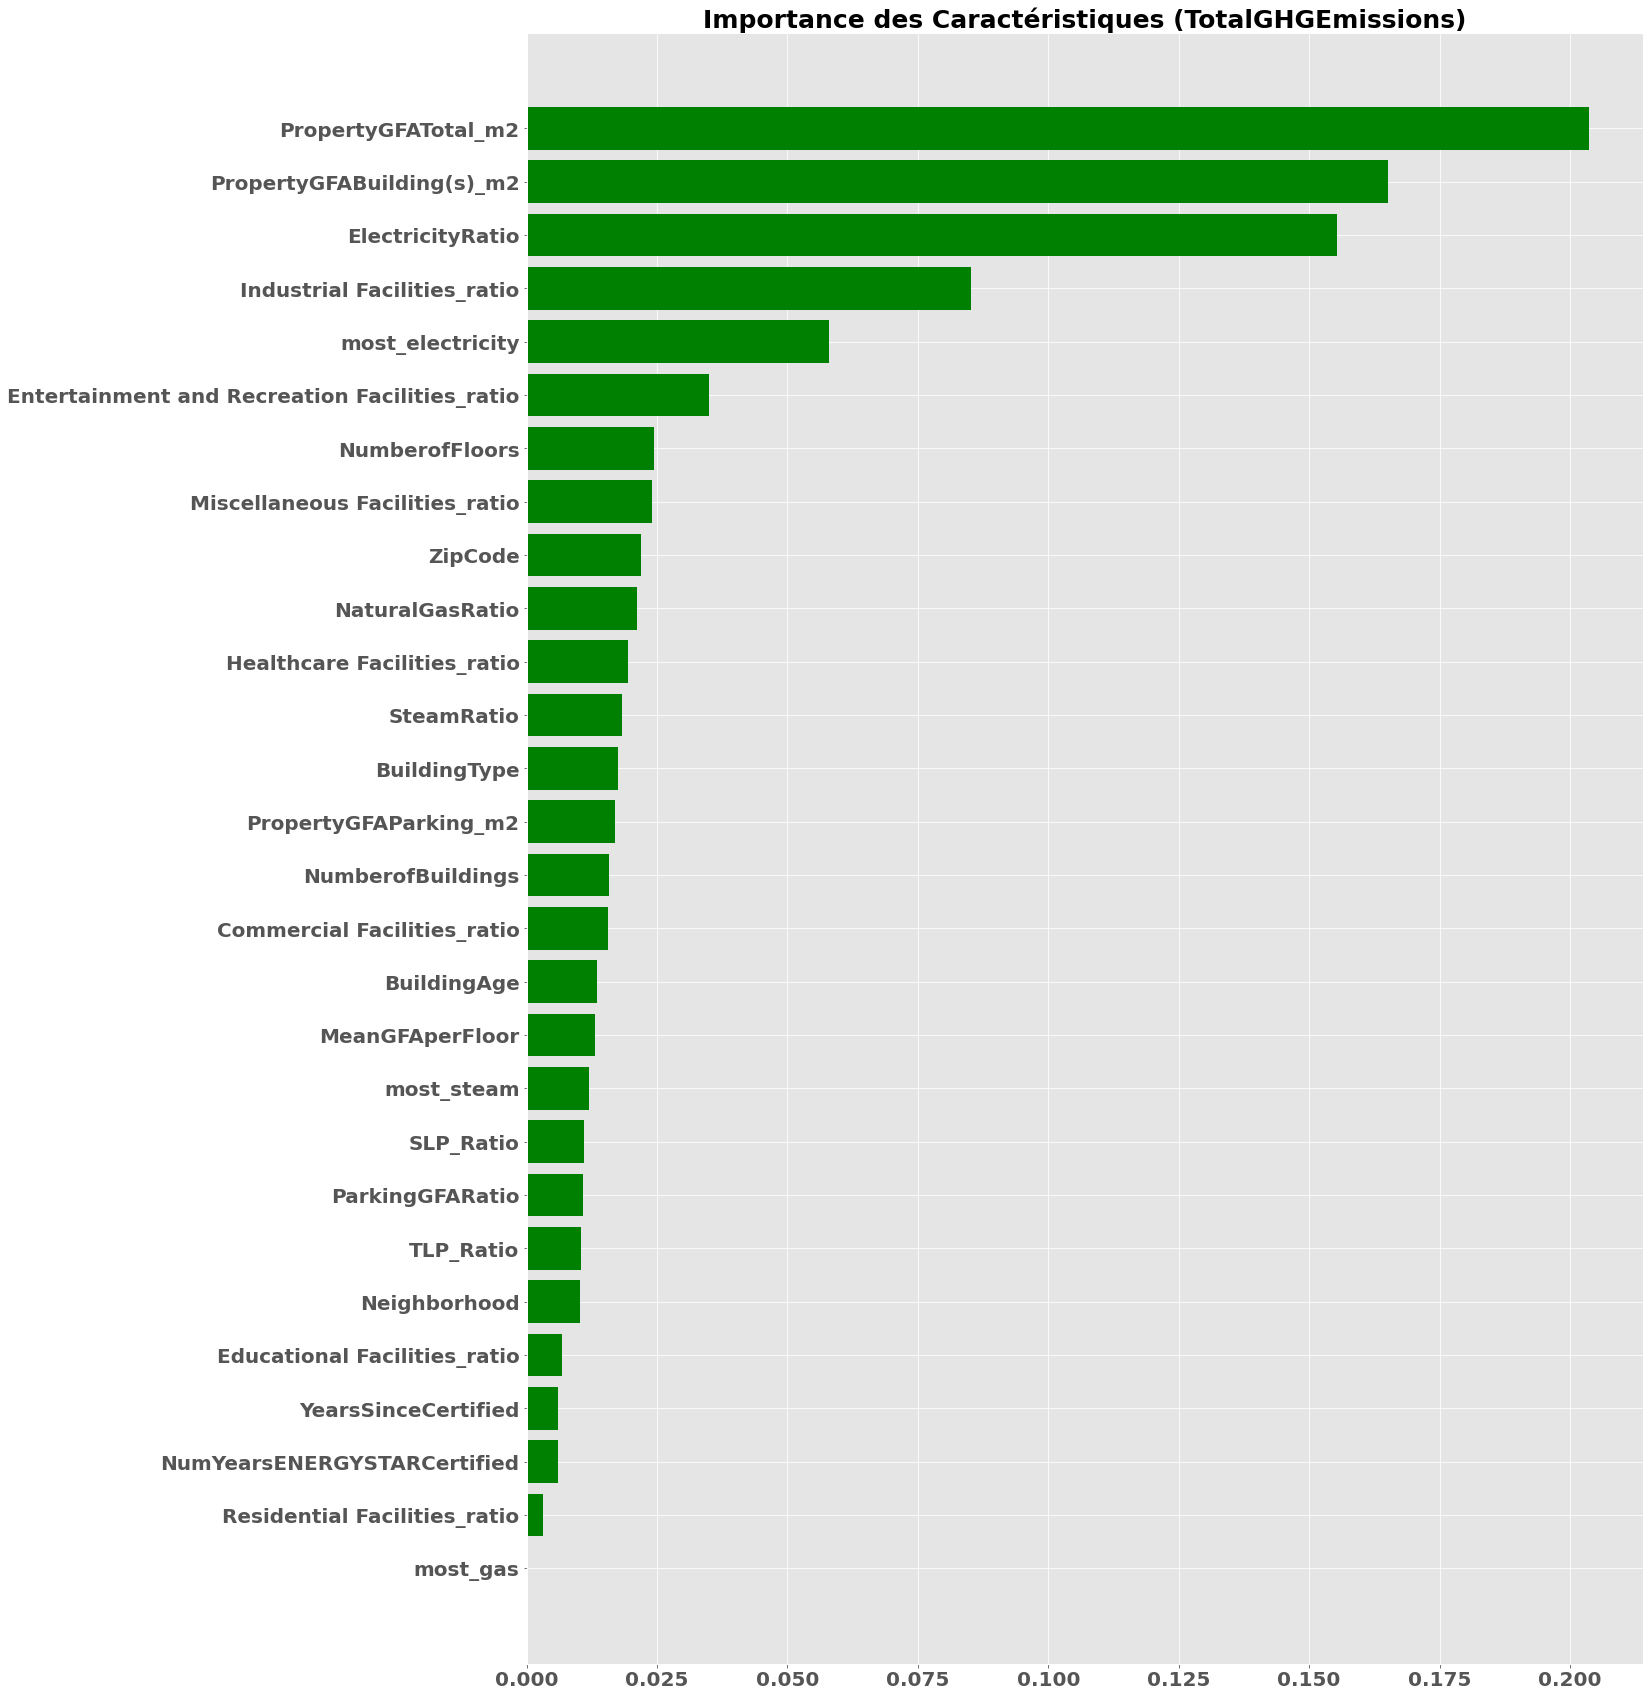

In [65]:
# Tracer l'importance des caractéristiques pour la colonne 'TotalGHGEmissions'
plot_feature_importance(X_train_encoded, y_train['log_emission'], 'TotalGHGEmissions')

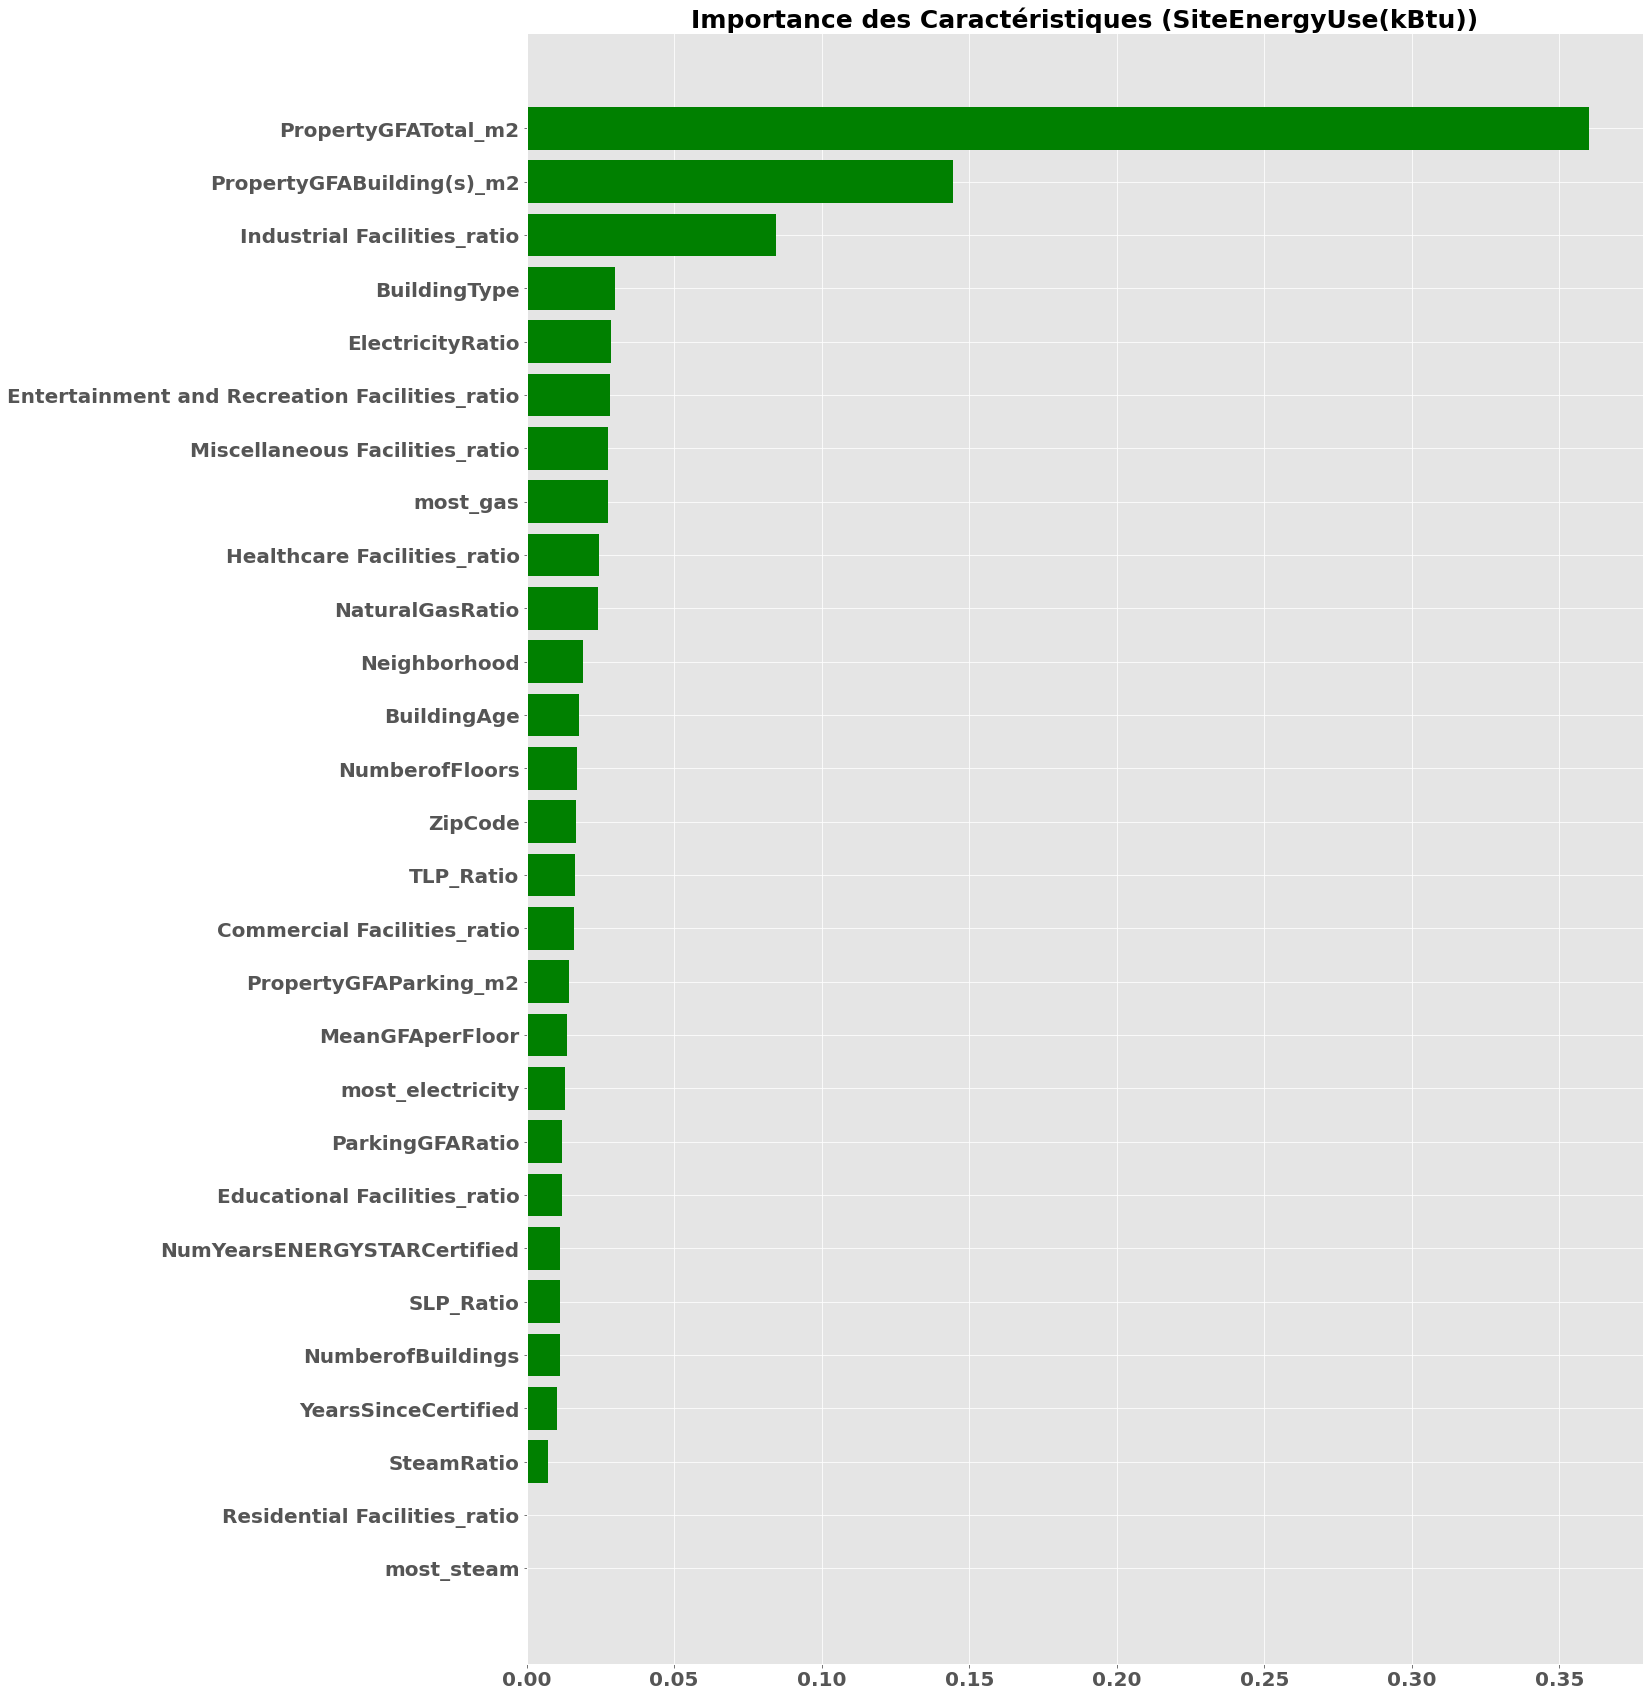

In [66]:
# Tracer l'importance des caractéristiques pour la colonne 'SiteEnergyUse(kBtu)'
plot_feature_importance(X_train_encoded, y_train['log_energie'], 'SiteEnergyUse(kBtu)')



Une fois les résultats sur l'importance des caractéristiques obtenus, j'ai également utilisé les méthodes LIME et SHAP pour obtenir une analyse plus précise de l'impact de chaque colonne sur la prédiction de chaque variable cible. Ces méthodes permettent de mieux comprendre comment chaque caractéristique contribue aux résultats du modèle.

LIME (Local Interpretable Model-Agnostic Explanations) est une méthode qui explique les prédictions d'un modèle en approximant localement son comportement à l'aide de modèles plus simples et interprétables. Elle attribue des poids à chaque caractéristique pour expliquer son influence sur la prédiction.

SHAP (SHapley Additive exPlanations) est une autre méthode d'explication qui se base sur la théorie des jeux pour attribuer des valeurs d'importance à chaque caractéristique en mesurant leur contribution marginale à la prédiction. Cela permet de quantifier l'impact de chaque caractéristique de manière plus précise.

En utilisant ces deux méthodes, j'ai pu obtenir des informations plus détaillées sur l'importance de chaque colonne dans la prédiction des variables cibles. Cela m'a permis de mieux comprendre les facteurs qui influencent les résultats du modèle et d'obtenir des explications plus précises pour chaque prédiction.

<a id='subsec:Lime'></a>
### A. Lime

In [67]:
import lime
from lime import lime_tabular

# Créer le pipeline XGBoost pour Lime
lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

# Ajuster le pipeline XGBoost sur les données d'entraînement encodées
lime_xgb_pipeline.fit(X_train_encoded, y_train['log_emission'])

# Obtenir le meilleur estimateur du pipeline XGBoost
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

# Créer l'explorateur LIME
explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                              feature_names=transformed_col_names)


In [68]:
import random

# Sélectionner un indice aléatoire de l'ensemble de données de test
idx = random.randint(1, len(X_test_encoded))

# Afficher la prédiction et la valeur réelle correspondante
print("Prédiction: ", lime_xgb_pipeline.predict(X_test_encoded.iloc[[idx]].values))
print("Réel:       ", y_test.iloc[idx]['log_emission'])

# Générer l'explication pour l'instance de test sélectionnée
explanation = explainer.explain_instance(X_test_encoded.iloc[[idx]].values[0],
                                         lime_xgb_pipeline.predict, num_features=len(transformed_col_names))


Prédiction:  [4.6579523]
Réel:        4.294014757350668


In [69]:
explanation.show_in_notebook()


In [70]:
lime_xgb_pipeline.fit(X_train_encoded, y_train['log_energie'])
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                              feature_names=transformed_col_names)
explanation = explainer.explain_instance(X_test_encoded.iloc[[idx]].values[0], lime_xgb_pipeline.predict,
                                         num_features=len(transformed_col_names))
explanation.show_in_notebook()


In [71]:
from matplotlib.ticker import FixedLocator, FixedFormatter

lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

def plot_lime_feature_importance(column_name):
    # Fit the XGBoost pipeline and get the best estimator
    lime_xgb_pipeline.fit(X_train_encoded, y_train[column_name])
    lxp = lime_xgb_pipeline.steps[-1][1].best_estimator_

    # Définir le LimeTabularExplainer
    explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                                  feature_names=transformed_col_names)
    explanations = [explainer.explain_instance(instance,
                                               lxp.predict,
                                               num_features=len(transformed_col_names)) 
                    for instance in X_test_encoded.values]

    # Calculer les importances des caractéristiques
    feature_importances = [exp.as_list() for exp in explanations]
    feature_importances = dict(sum(feature_importances, []))

    # Trier les importances des caractéristiques par valeur absolue
    sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=False)

    # Tracer les importances des caractéristiques
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.barh(range(len(sorted_importances)), [val for _, val in sorted_importances],
            color=["red" if val < 0 else "green" for _, val in sorted_importances])
    ax.set_yticks(range(len(sorted_importances)))
    ax.set_yticklabels([name for name, _ in sorted_importances], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xticklabels(ax.get_xticks(), fontsize=20, fontweight='bold')
    ax.set_title("Importance des Caractéristiques (Lime) - " + column_name, fontsize=25, fontweight='bold')

    # Fixer les emplacements et les étiquettes des graduations de l'axe des y
    ax.yaxis.set_major_locator(FixedLocator(range(len(sorted_importances))))
    ax.yaxis.set_major_formatter(FixedFormatter([name for name, _ in sorted_importances]))

    plt.show()


<ipython-input-71-0f5ac7032818>:34: UserWarning:

FixedFormatter should only be used together with FixedLocator



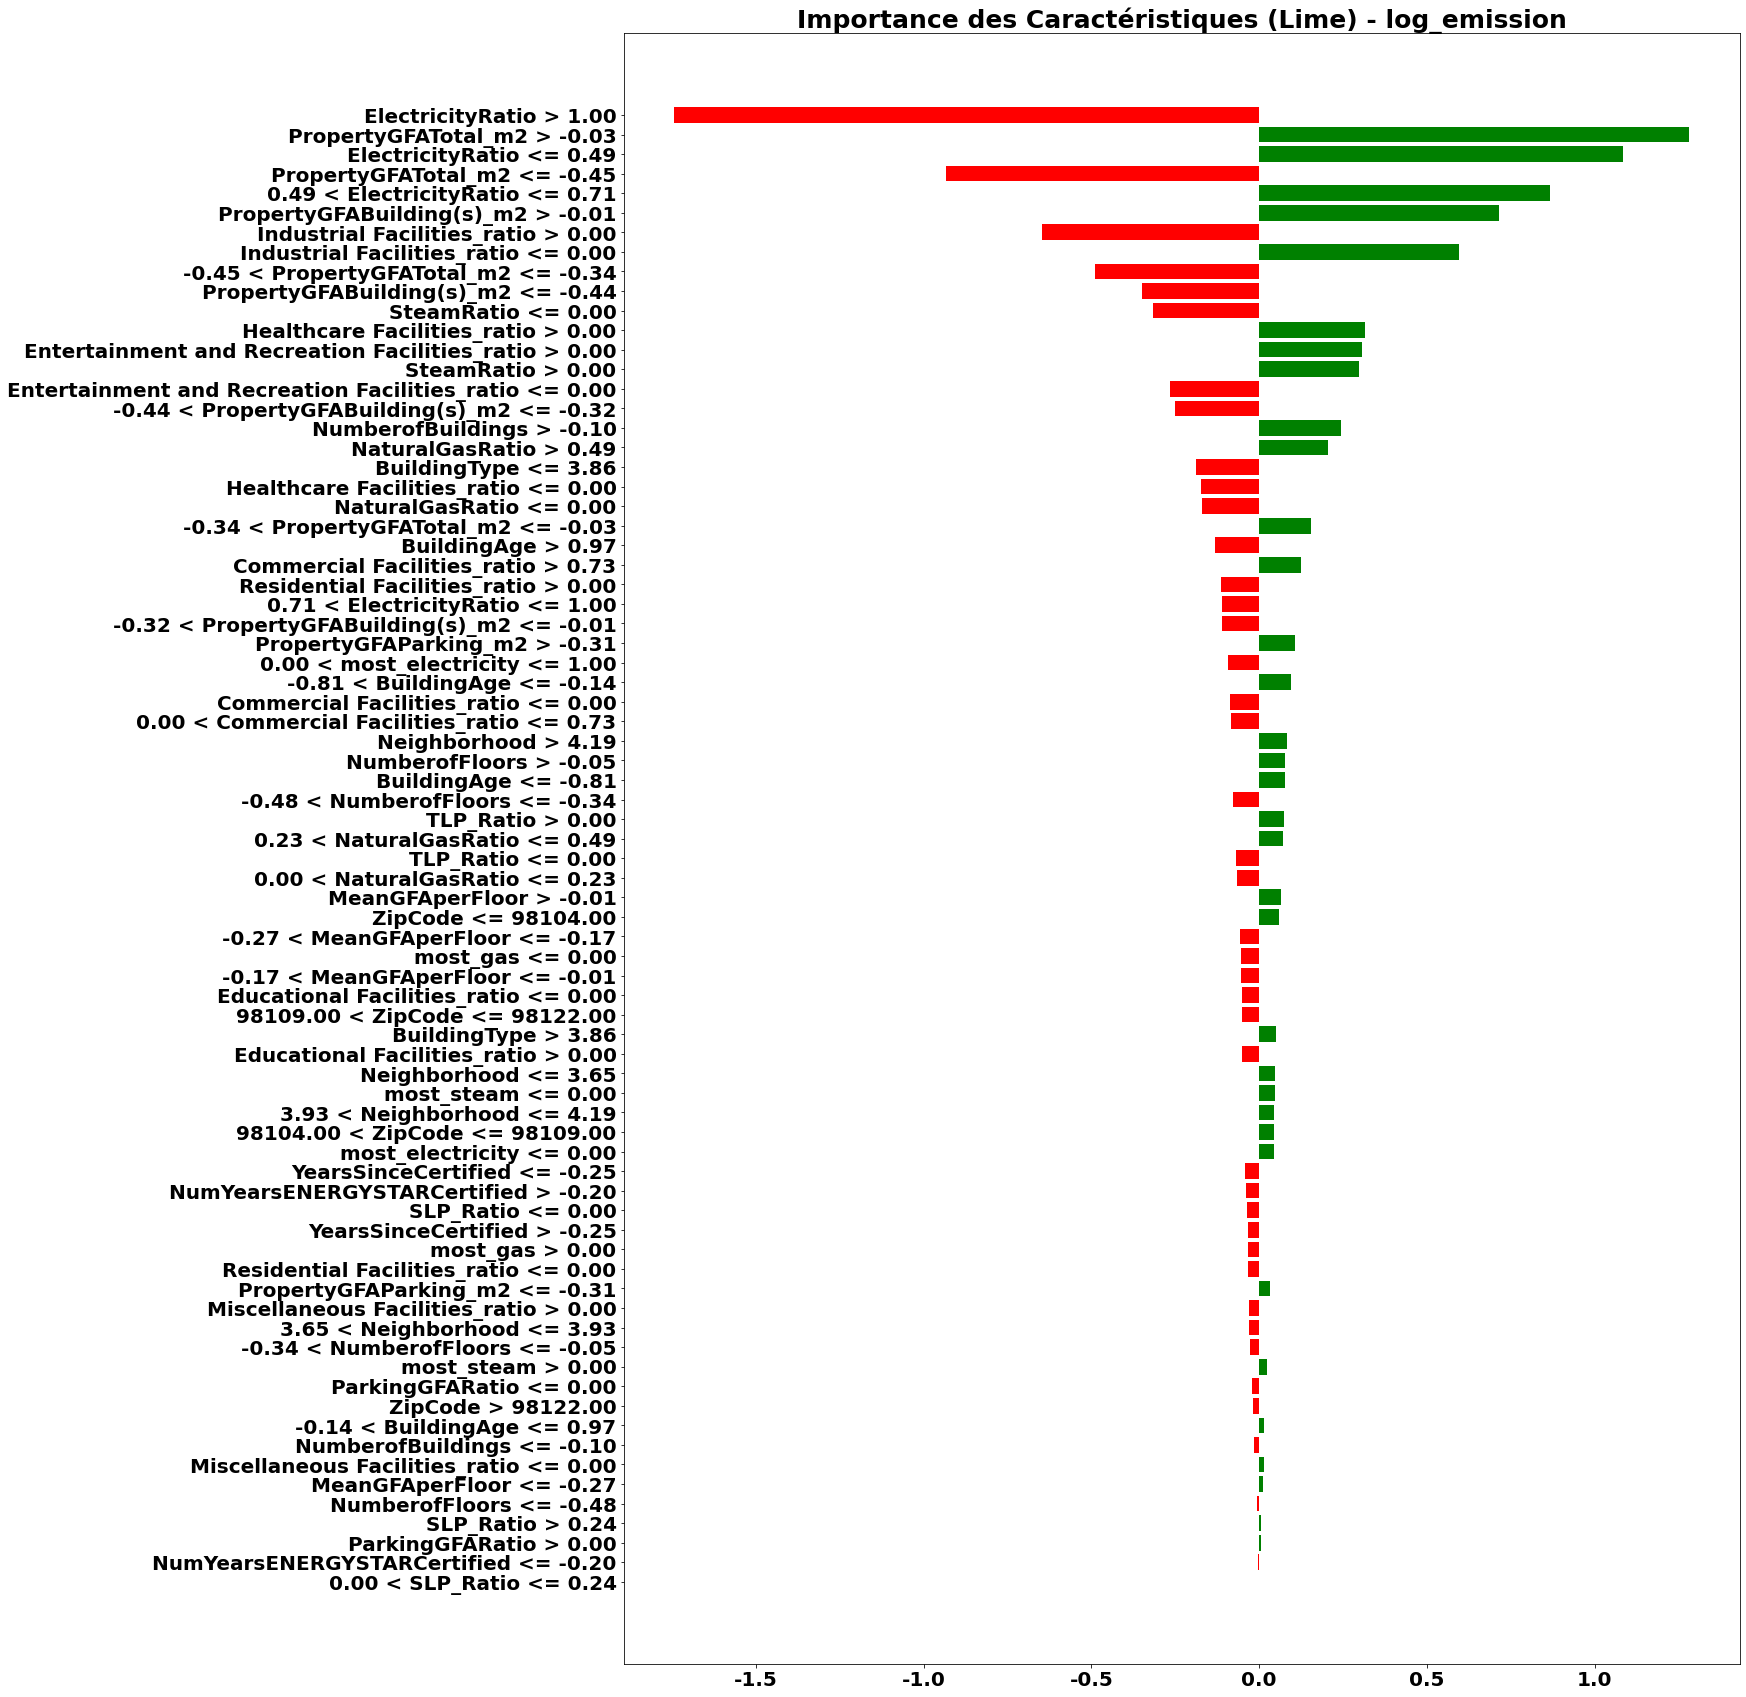

In [72]:
# Call the function for 'TotalGHGEmissions' column
plot_lime_feature_importance('log_emission')

<ipython-input-71-0f5ac7032818>:34: UserWarning:

FixedFormatter should only be used together with FixedLocator



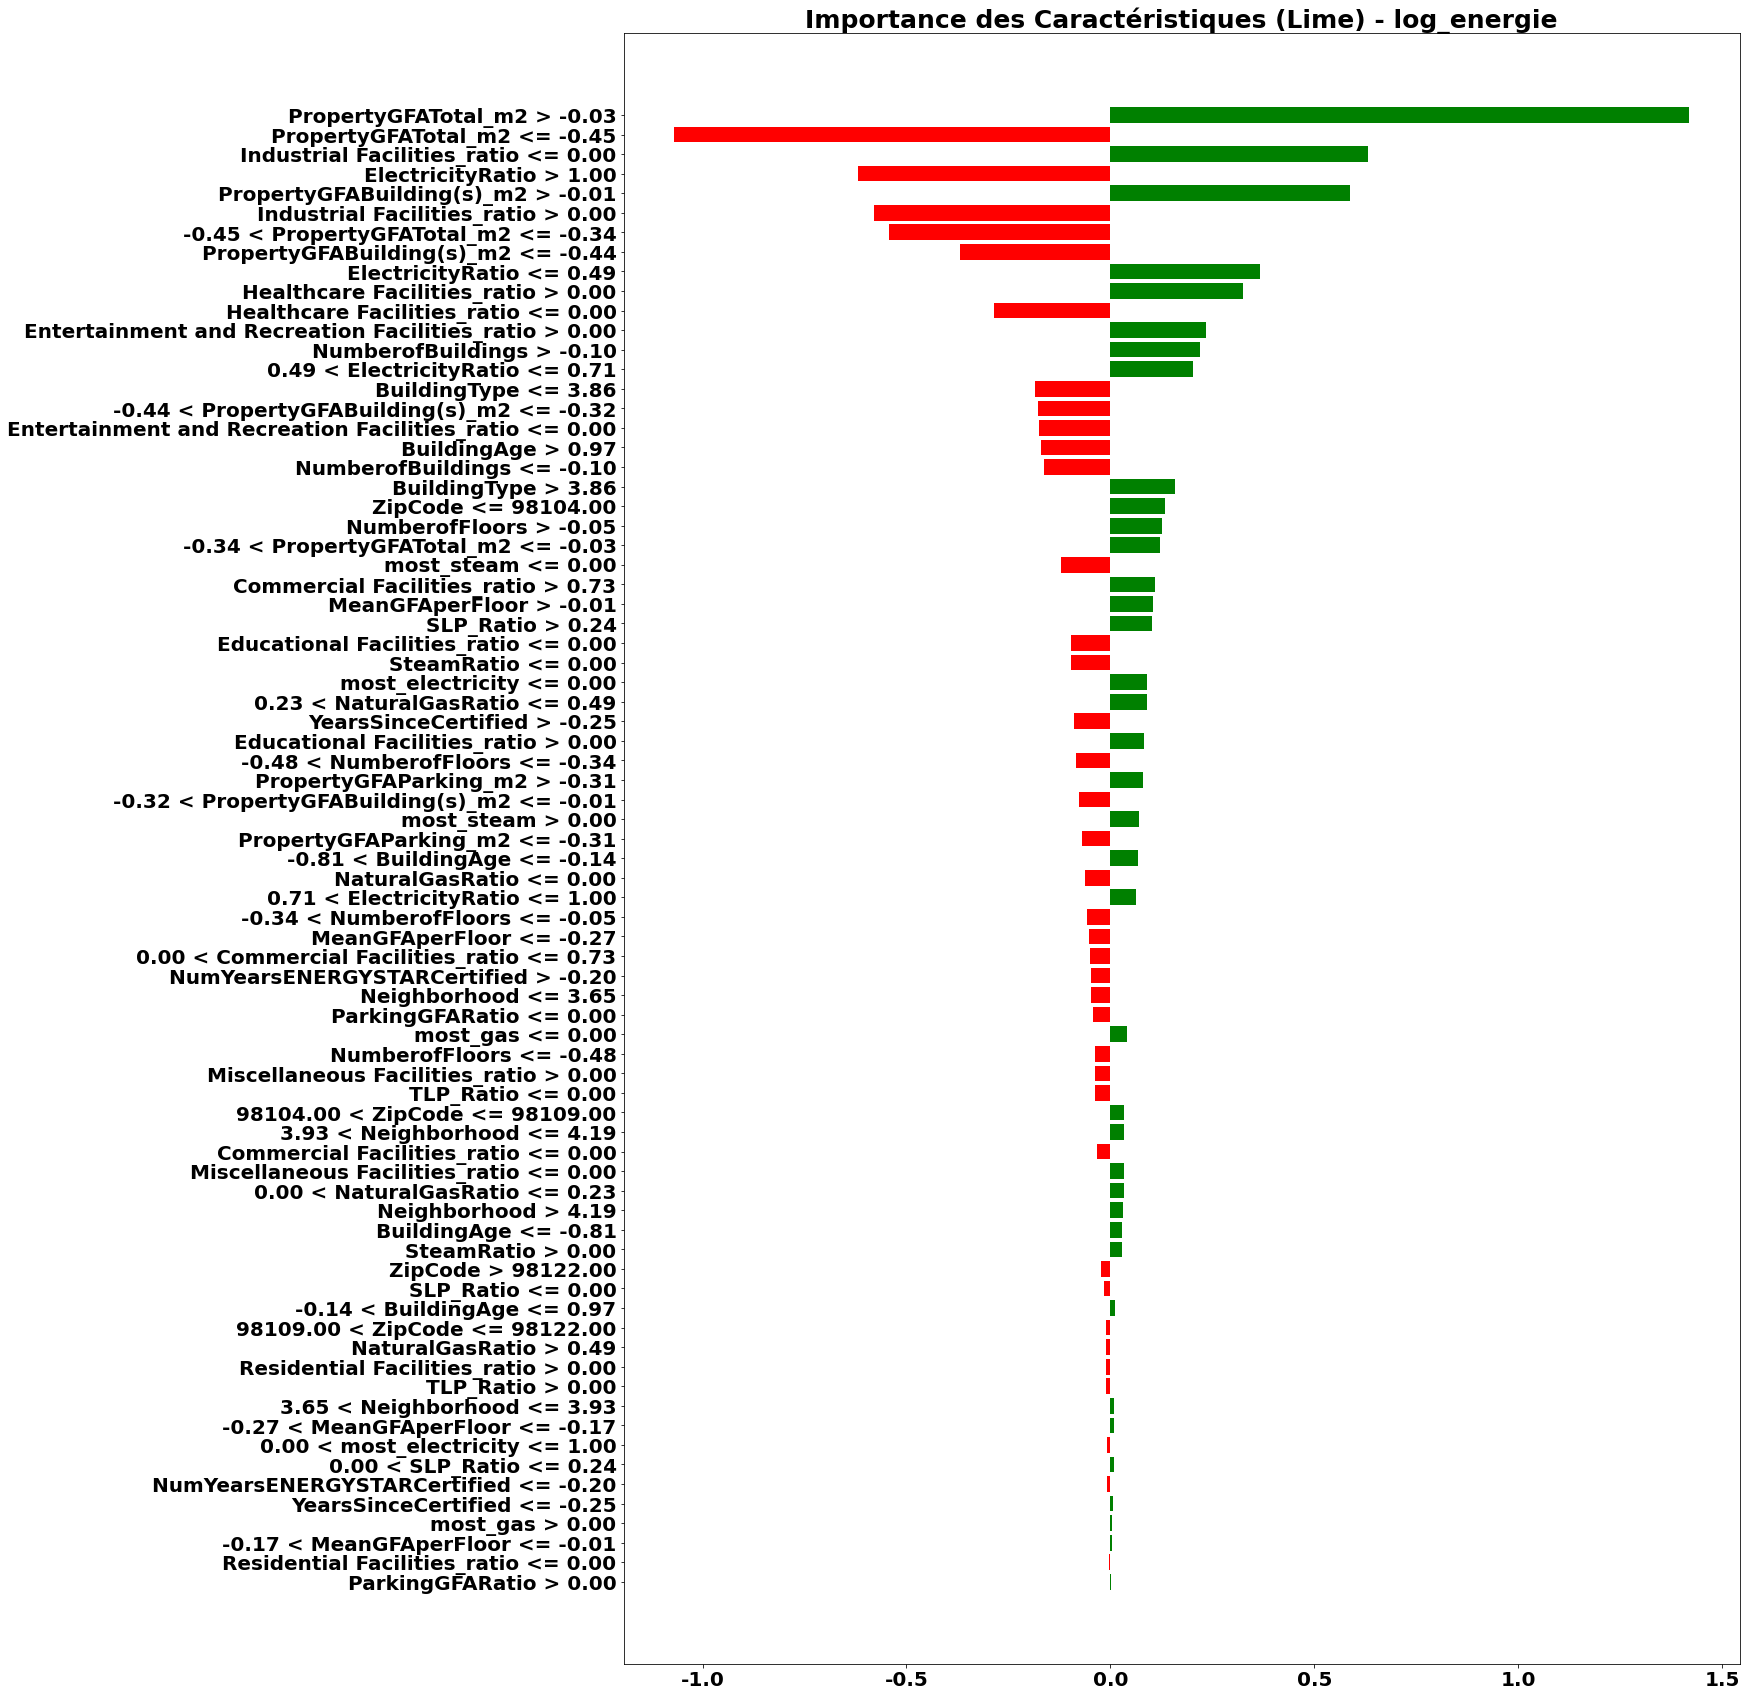

In [73]:
# tracer l'importance des caractéristiques basée sur LIME pour la colonne 'log_energie'
plot_lime_feature_importance('log_energie')

<a id='subsec:SHAP'></a>
### B. SHAP

In [86]:
import shap
import warnings
warnings.filterwarnings("ignore")

In [75]:
shap.initjs()


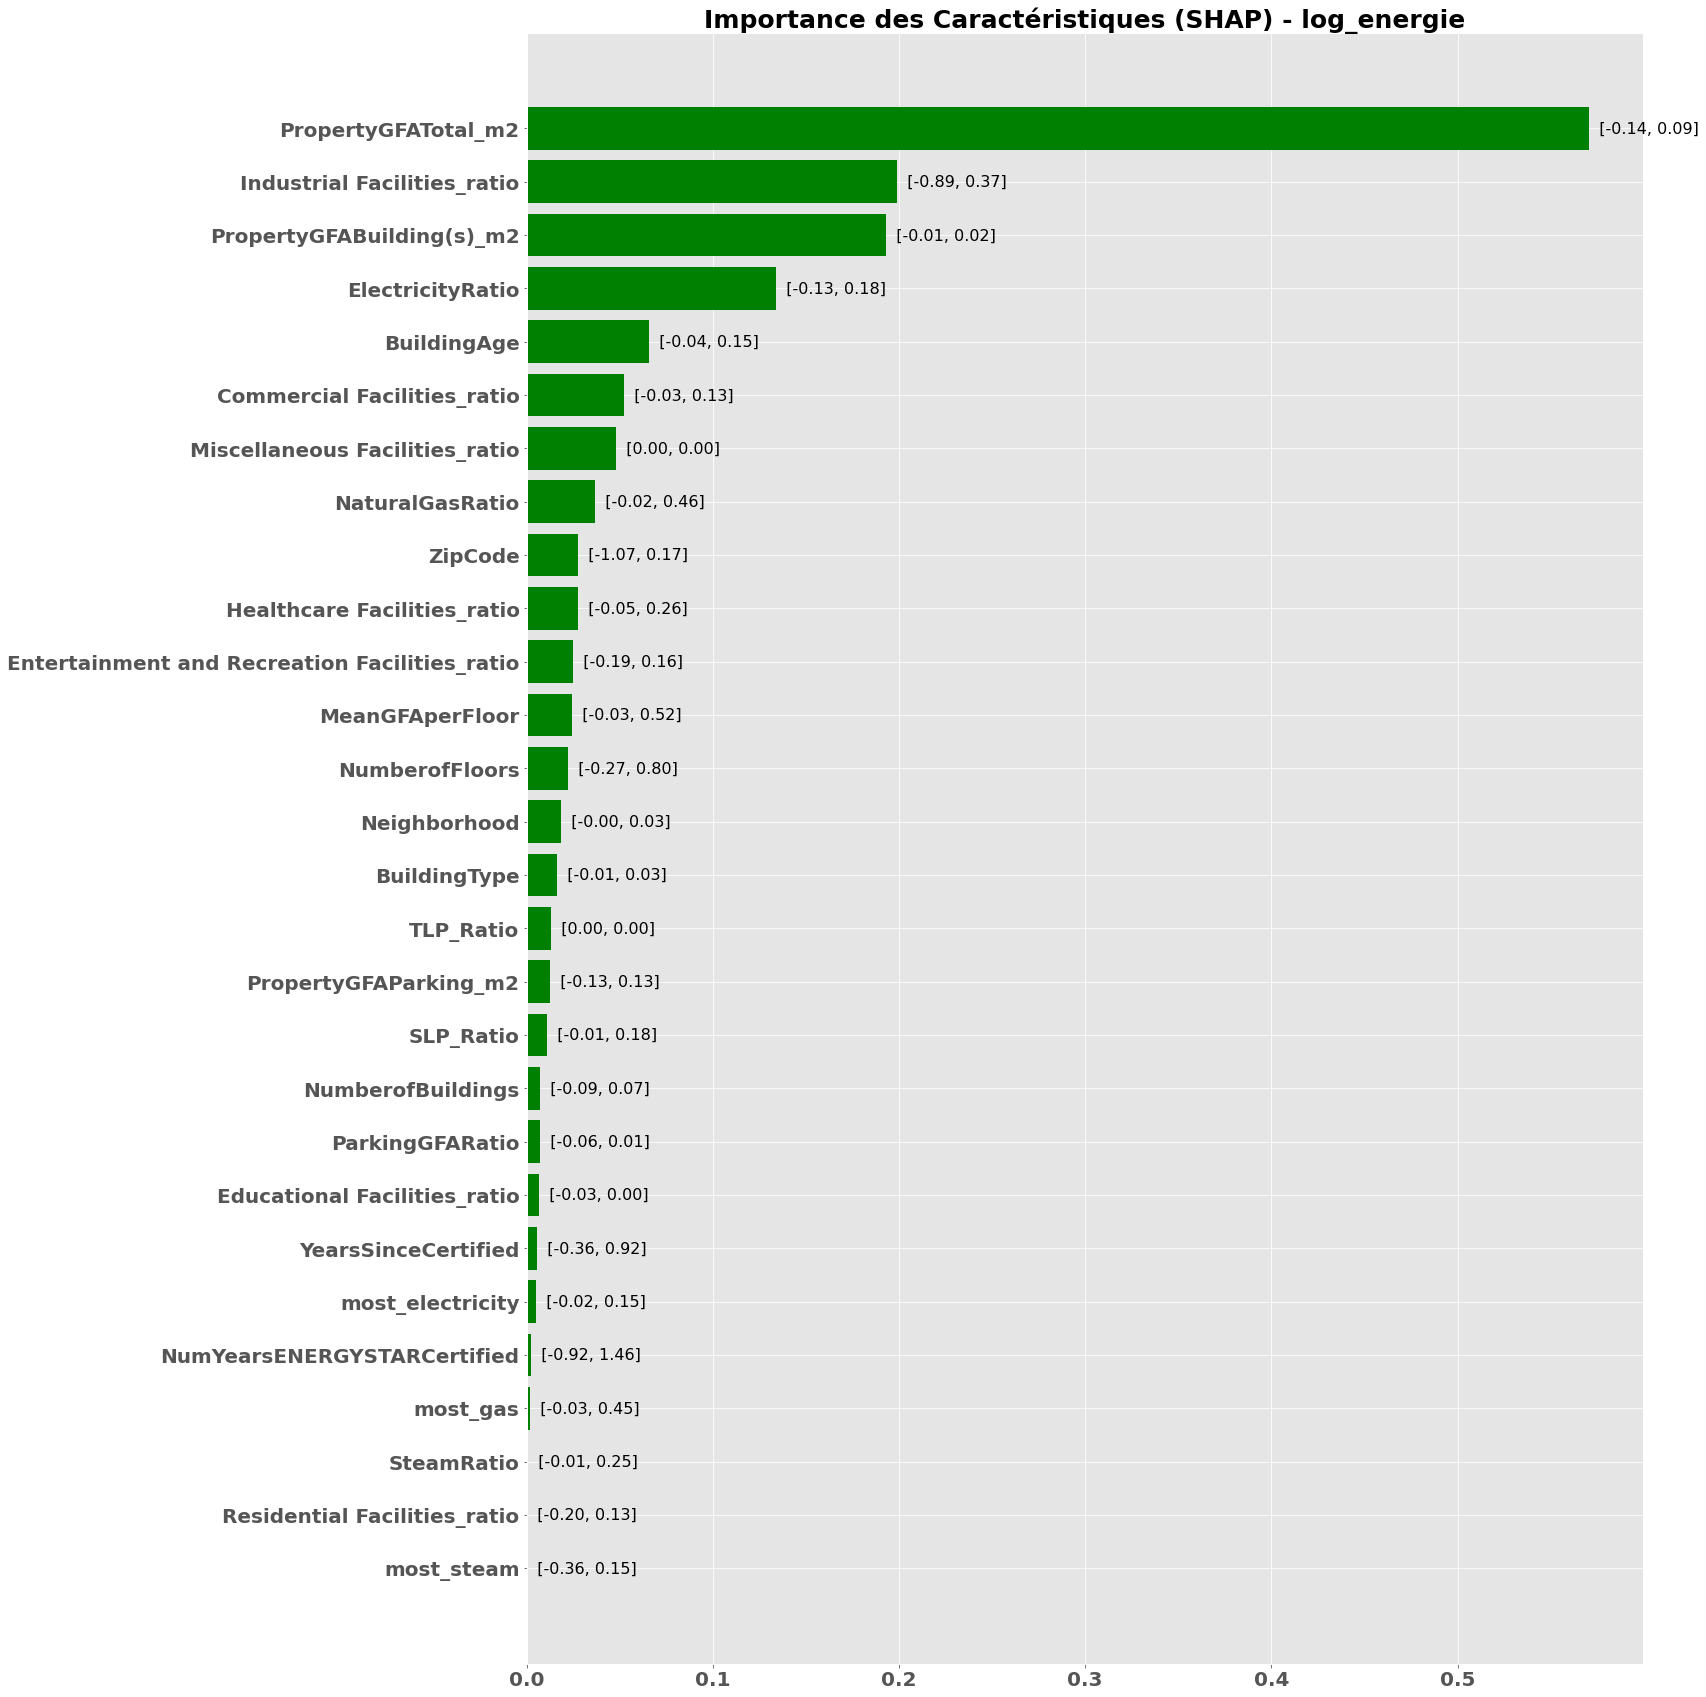

In [76]:
def plot_shap_feature_importance(column_name):
    # Créer le pipeline XGBoost
    shap_xgb_pipeline = Pipeline([
        ('grid_search', xgb_grid_search)
    ])

    shap_xgb_pipeline.fit(X_train_encoded, y_train[column_name])
    sxp = shap_xgb_pipeline.steps[-1][1]
    sxp = sxp.best_estimator_

    # Importance des caractéristiques SHAP
    explainer = shap.TreeExplainer(sxp)
    shap_values = explainer.shap_values(X_test_encoded)

    # Calculer l'importance des caractéristiques SHAP
    shap_feature_importances = np.abs(shap_values).mean(axis=0)
    sorted_shap_importances = sorted(zip(transformed_col_names, shap_feature_importances),
                                     key=lambda x: x[1], reverse=False)

    # Tracer l'importance des caractéristiques SHAP
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_shap_importances)), [val for _, val in sorted_shap_importances], color="green")
        ax.set_yticks(range(len(sorted_shap_importances)))
        ax.set_yticklabels([name for name, _ in sorted_shap_importances], fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Importance des Caractéristiques (SHAP) - {column_name}", fontsize=25, fontweight='bold')

        # Ajouter des informations sur la plage de données
        for i, (_, importance) in enumerate(sorted_shap_importances):
            min_value = np.min(shap_values[:, i])
            max_value = np.max(shap_values[:, i])
            ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

    plt.show()

# Appeler la fonction pour la colonne 'log_energie'
plot_shap_feature_importance('log_energie')


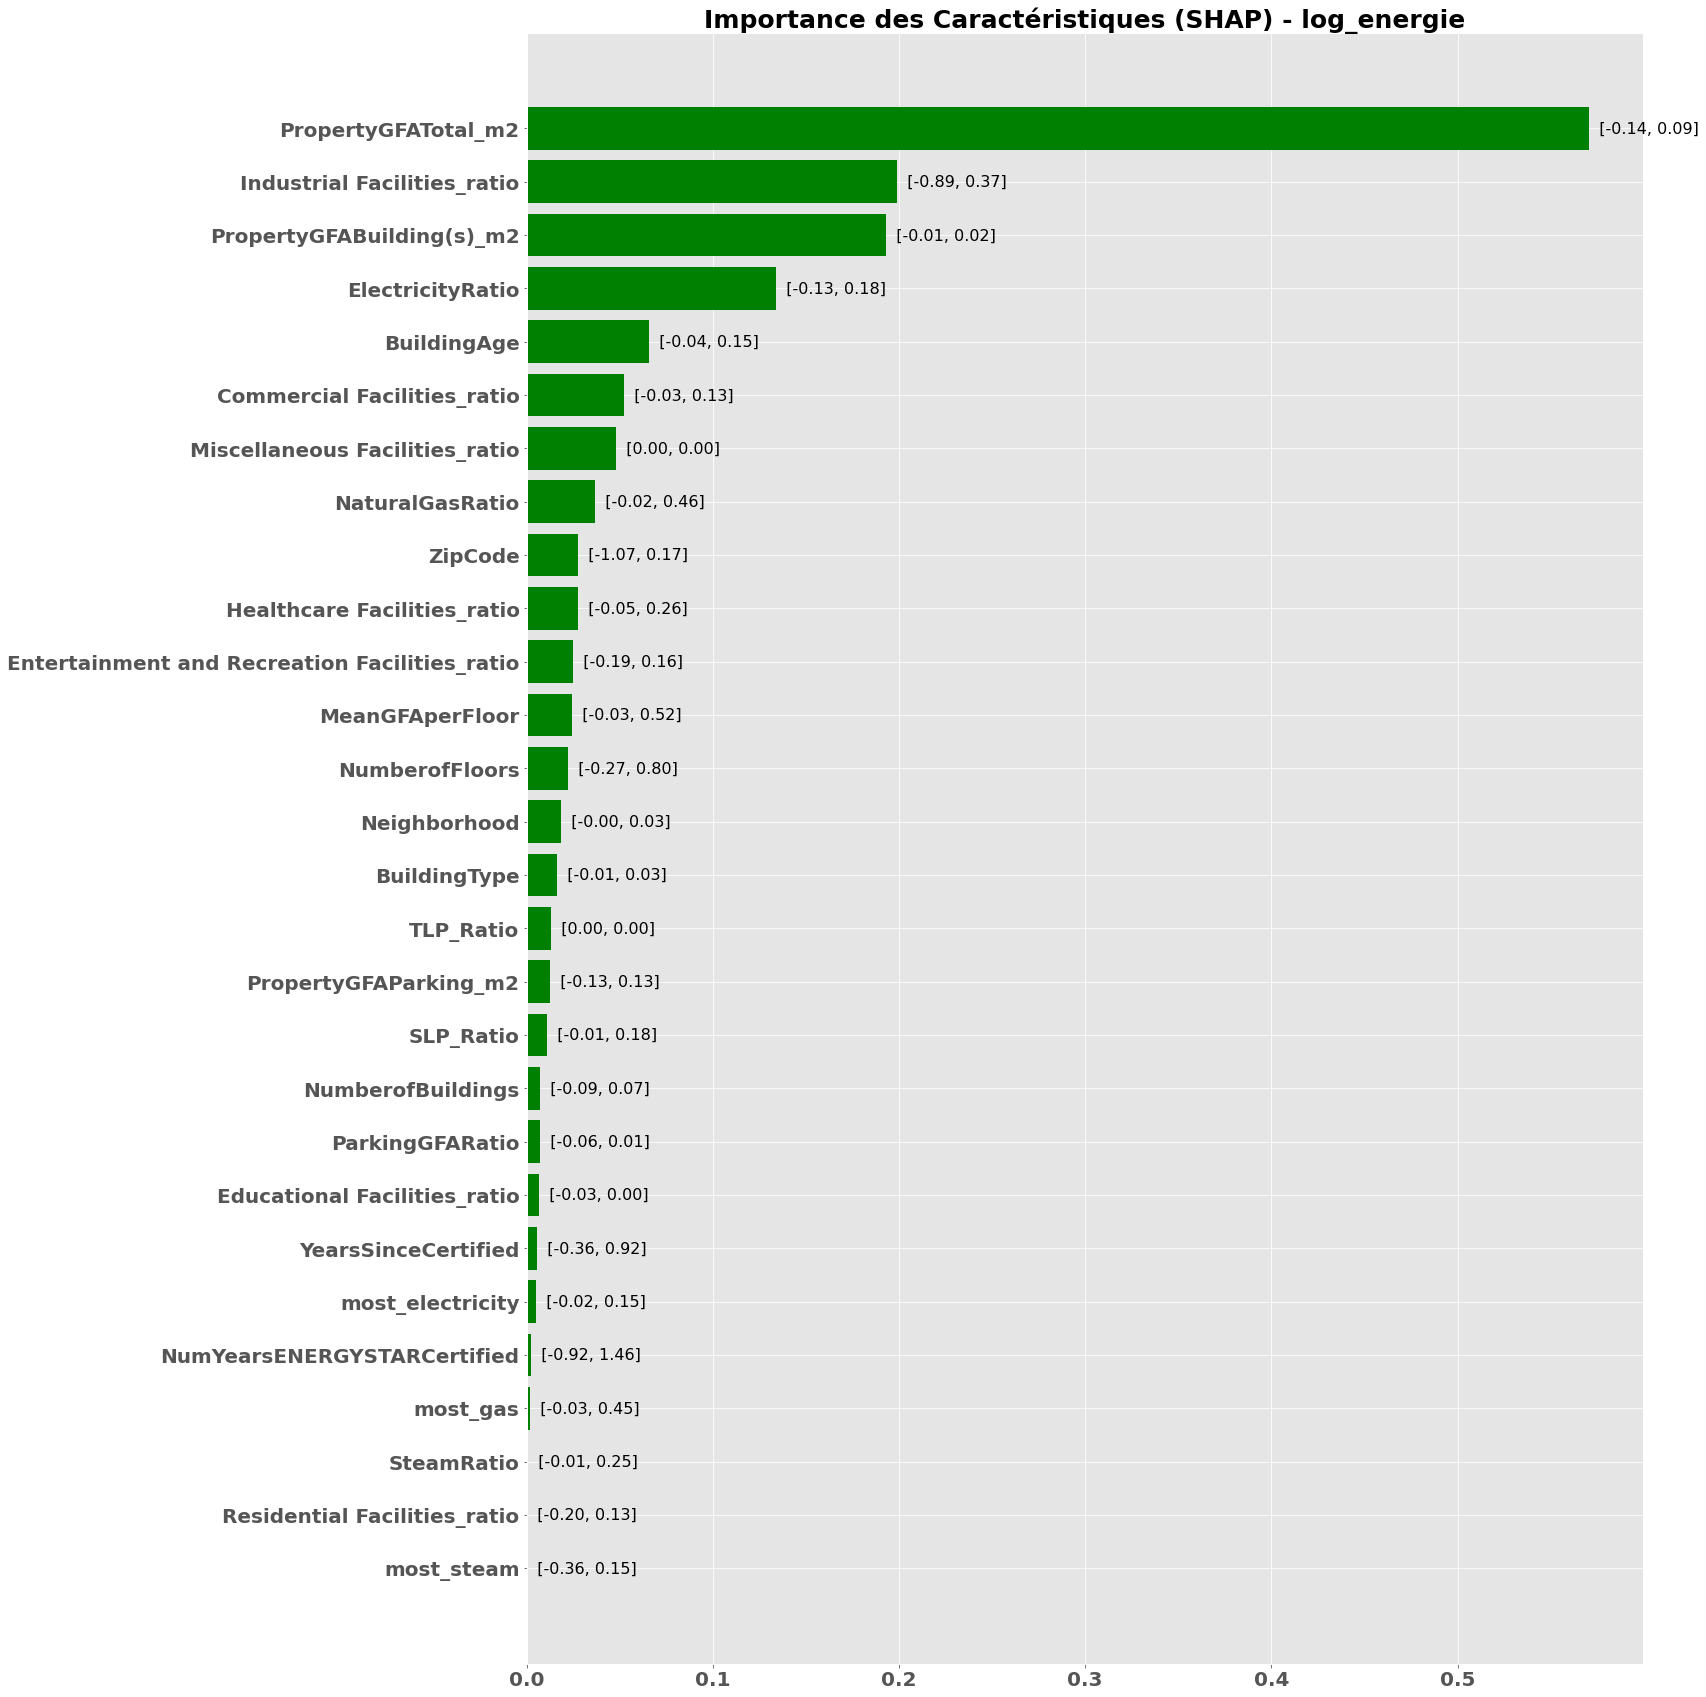

In [77]:
# tracer l'importance des caractéristiques basée sur SHAP pour la colonne 'log_energie' 
plot_shap_feature_importance('log_energie')

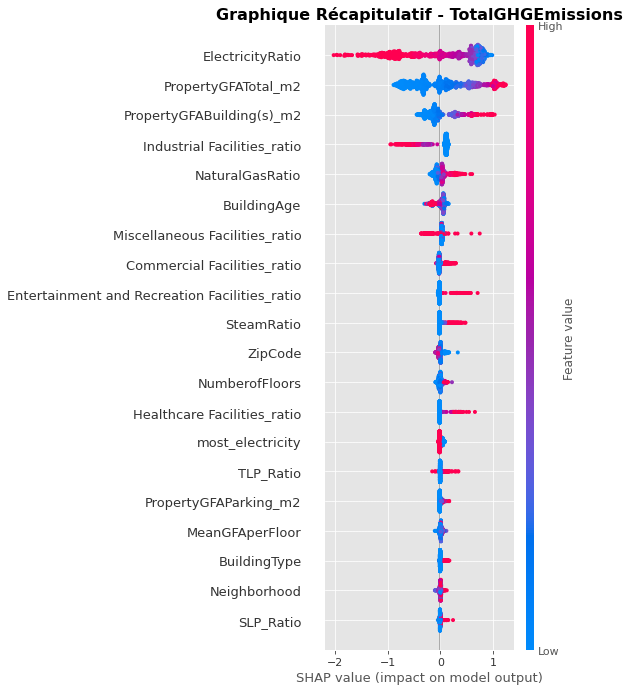

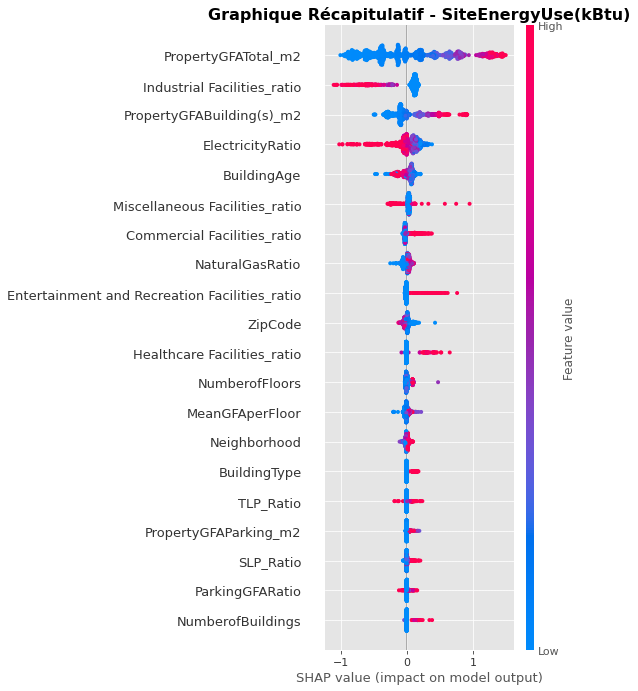

In [78]:
def generate_summary_plot(X, y, transformed_col_names, target_name):
    # Créer le pipeline XGBoost
    xgb_pipeline = Pipeline([
        ('grid_search', xgb_grid_search)
    ])
    
    # Ajuster le pipeline XGBoost et obtenir le meilleur estimateur
    xgb_pipeline.fit(X, y)
    xp = xgb_pipeline.steps[-1][1].best_estimator_
    
    # Créer l'explorateur SHAP et calculer les valeurs SHAP
    explainer = shap.TreeExplainer(xp)
    shap_values = explainer.shap_values(X)
    
    # Générer le graphique récapitulatif
    with plt.style.context("ggplot"):
        shap.summary_plot(shap_values, X, feature_names=transformed_col_names, show=False)
        plt.title("Graphique Récapitulatif - " + target_name, fontsize=16, fontweight='bold')
        plt.show()

# Générer un graphique récapitulatif pour 'TotalGHGEmissions'
generate_summary_plot(X_train_encoded, y_train['log_emission'], transformed_col_names, 'TotalGHGEmissions')

# Générer un graphique récapitulatif pour 'SiteEnergyUse(kBtu)'
generate_summary_plot(X_train_encoded, y_train['log_energie'], transformed_col_names, 'SiteEnergyUse(kBtu)')


In [79]:
def plot_dependence_shap(X_train, X_test, y_train, column_name, transformed_col_names, features_to_plot):
    # Créer le pipeline XGBoost
    shap_xgb_pipeline = Pipeline([('grid_search', xgb_grid_search)])

    # Ajuster le pipeline XGBoost pour obtenir le meilleur estimateur
    shap_xgb_pipeline.fit(X_train, y_train[column_name])
    sxp = shap_xgb_pipeline.steps[-1][1].best_estimator_

    # Créer l'explorateur SHAP TreeExplainer
    explainer = shap.TreeExplainer(sxp)

    # Calculer les valeurs SHAP pour l'ensemble de test
    shap_values = explainer.shap_values(X_test)

    # Générer les graphiques de dépendance pour les caractéristiques sélectionnées
    with plt.style.context("ggplot"):
        for feature in features_to_plot:
            shap.dependence_plot(feature, shap_values, X_test, feature_names=transformed_col_names, show=False)
            plt.title(f"Graphique de Dépendance - {feature} ({column_name})", fontsize=16, fontweight='bold')
            plt.scatter(X_test[feature], y_test[column_name], color='red', alpha=0.3)
            plt.show()

# Spécifier les caractéristiques à afficher dans les graphiques de dépendance
features_to_plot = ['ElectricityRatio', 'PropertyGFATotal_m2', 'BuildingType']


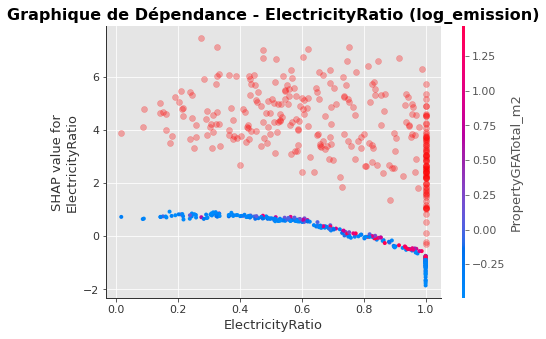

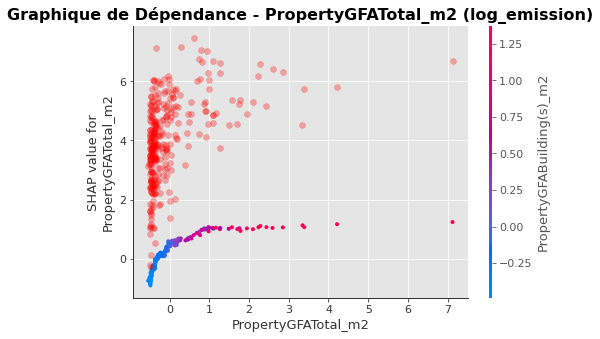

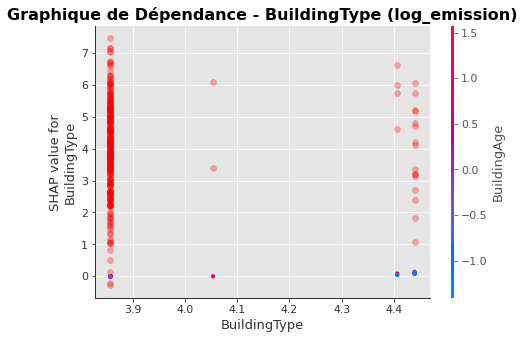

In [80]:
# Call the function for the 'TotalGHGEmissions' target
plot_dependence_shap(X_train_encoded, X_test_encoded, y_train, 'log_emission', transformed_col_names, features_to_plot)



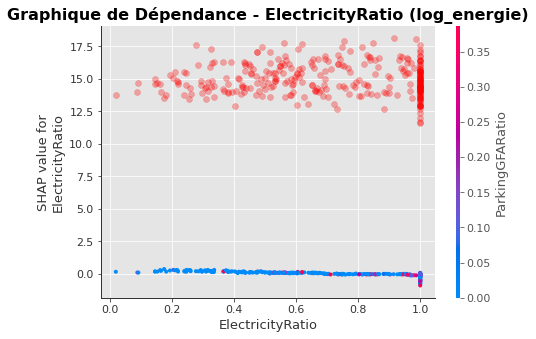

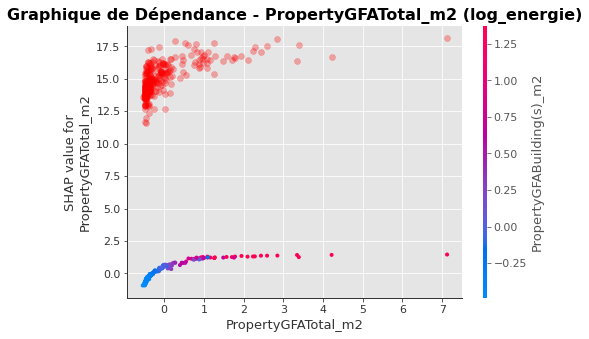

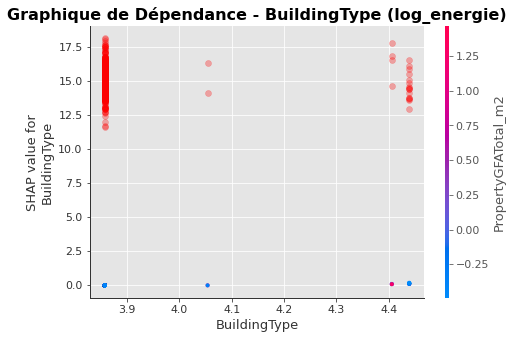

In [81]:
# Call the function for the 'SiteEnergyUse(kBtu)' target
plot_dependence_shap(X_train_encoded, X_test_encoded, y_train, 'log_energie', transformed_col_names, features_to_plot)


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/303 [00:00<?, ?it/s]

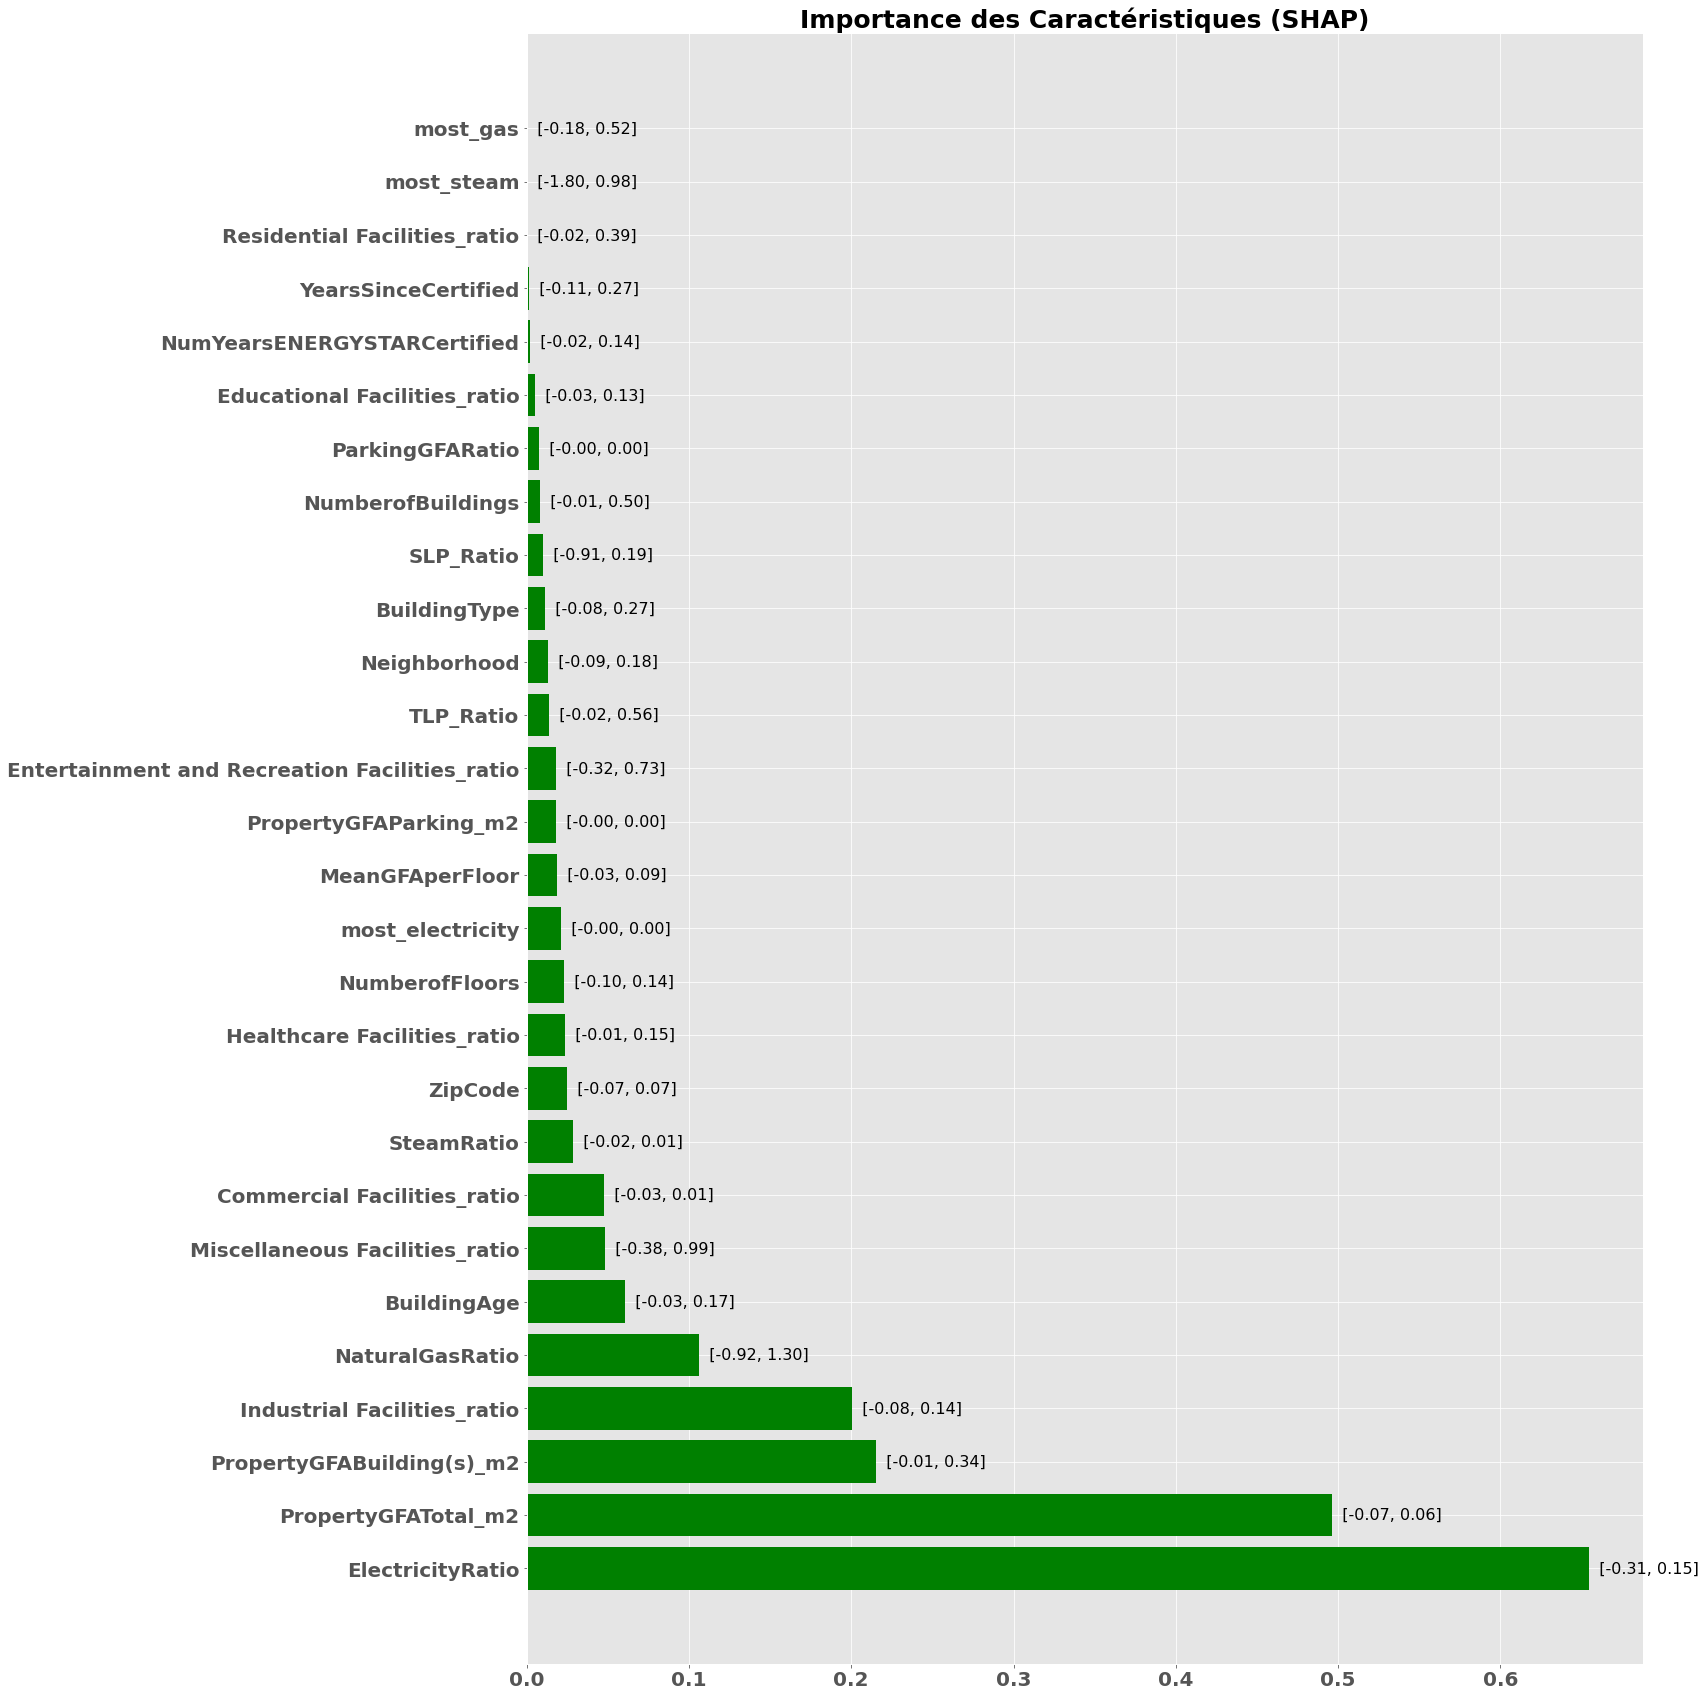

In [82]:
# Créer le pipeline XGBoost
lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

# Ajuster le pipeline XGBoost
lime_xgb_pipeline.fit(X_train_encoded, y_train['log_emission'])
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

# Sommaire des données de fond
background_summary = shap.sample(X_train_encoded, 300)  # Ajuster le nombre d'échantillons selon vos besoins

# Kernel SHAP : importance des caractéristiques
explainer = shap.KernelExplainer(lxp.predict, background_summary)
shap_values = explainer.shap_values(X_test_encoded)

# Calculer l'importance des caractéristiques SHAP
shap_feature_importances = np.abs(shap_values).mean(axis=0)
sorted_shap_importances = sorted(zip(transformed_col_names, shap_feature_importances),
                                 key=lambda x: x[1], reverse=True)

# Tracer l'importance des caractéristiques SHAP
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.barh(range(len(sorted_shap_importances)), [val for _, val in sorted_shap_importances], color="green")
    ax.set_yticks(range(len(sorted_shap_importances)))
    ax.set_yticklabels([name for name, _ in sorted_shap_importances], fontsize=20, fontweight='bold')
    plt.xticks(fontsize=20, fontweight='bold')
    ax.set_title("Importance des Caractéristiques (SHAP)", fontsize=25, fontweight='bold')

    # Ajouter les informations sur la plage des données
    for i, (_, importance) in enumerate(sorted_shap_importances):
        min_value = np.min(shap_values[:, i])
        max_value = np.max(shap_values[:, i])
        ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

plt.show()


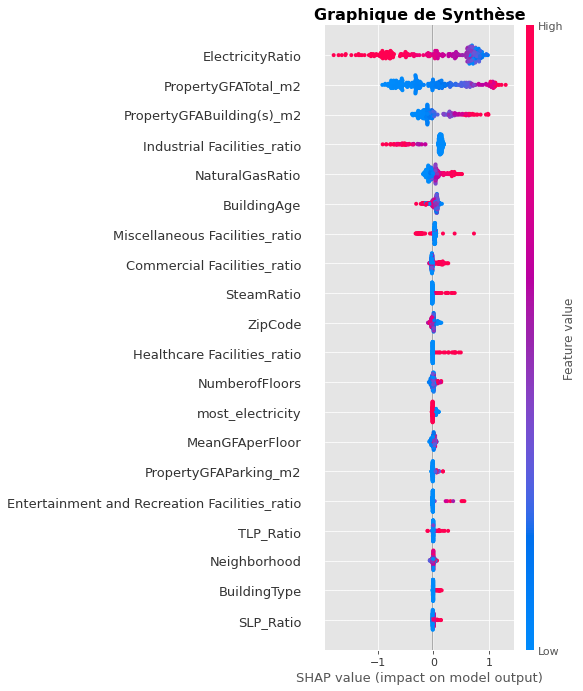

In [83]:
# Créer un graphique de synthèse
with plt.style.context("ggplot"):
    shap.summary_plot(shap_values, X_test_encoded, feature_names=transformed_col_names, show=False)
    plt.title("Graphique de Synthèse", fontsize=16, fontweight='bold')
    plt.show()


In [84]:
shap.initjs()

# Choisir un index spécifique (posidx) de l'instance à visualiser
posidx = 0

# Générer le graphique de force pour l'instance choisie
shap.force_plot(explainer.expected_value, shap_values[posidx], features=X_test_encoded.iloc[posidx])


In [85]:
shap.initjs()

# Générer le graphique de force
fp_glb = shap.force_plot(explainer.expected_value, shap_values, features=X_test_encoded, out_names='toxic', link='logit')

# Afficher le graphique de force
from IPython.display import display
display(fp_glb)


<a id='sec:conc'></a>
## VI. Conclusion

Tout d'abord, nous avons séparé nos données en ensembles d'entraînement et de test pour évaluer les performances des modèles. Ensuite, nous avons exploré plusieurs modèles de régression, y compris la régression linéaire multivariée, les modèles linéaires régularisés (ElasticNet, Lasso et Ridge), le Support Vector Regression (SVR) et les modèles non-linéaires tels que XGBoost et RandomForestRegressor.

Pour sélectionner les meilleurs modèles, nous avons utilisé la validation croisée et les métriques d'évaluation telles que l'erreur absolue moyenne (MAE) et le coefficient de détermination (R²). Nous avons constaté que les modèles XGBoost et RandomForestRegressor ont donné les meilleures performances pour prédire les émissions de CO2 et la consommation d'énergie totale.

Ensuite, nous avons utilisé Lime et SHAP pour analyser l'importance des caractéristiques dans nos modèles. Lime nous a permis d'expliquer les prédictions individuelles en mettant en évidence les caractéristiques les plus influentes. SHAP nous a fourni une vue globale de l'importance des caractéristiques en utilisant des mesures basées sur la valeur Shapley.

En conclusion, ce projet a démontré que la méthode XGBoost permet d'obtenir les meilleurs scores R² pour les valeurs logarithmiques des variables cibles. De plus, l'analyse de l'importance des caractéristiques à l'aide des méthodes Lime et SHAP a révélé que les colonnes Property GFA total_m2, Indistrial Facilities ratio, Property GFA Building_m2 et electricity ratio sont particulièrement significatives pour prédire les valeurs cibles. Ces résultats fournissent des informations précieuses pour prendre des décisions et mettre en œuvre des stratégies visant à réduire la consommation d'énergie et les émissions de gaz dans les bâtiments de Seattle.